In [2]:
import metacells as mc
import anndata as ad
import sys
import os
import random
import glob
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as pe
import seaborn as sb
from adjustText import adjust_text
from scipy import sparse,stats,cluster,io
from statsmodels.stats import multitest
import warnings
warnings.filterwarnings('ignore')

# Downloading the data

In [ ]:
if any([not os.path.exists(path) for path in ["data","figs","gdb","objs"]]):
    os.system("wget https://mtec-multiome.s3.eu-west-1.amazonaws.com/mtecs_multiome_data.tar.gz")

## extract the .tar.gz file

In [ ]:
os.system("tar xvzf mtecs_multiome_data.tar.gz")

## remove the .tar.gz file

In [ ]:
if os.path.exists('mtecs_multiome_data.tar.gz'):
    os.system("rm -f mtecs_multiome_data.tar.gz")

## Set Configurations

### logging configs

In [963]:
log = mc.ut.logger()

### setting directories:

In [ ]:
fig_dir = './figs/'

obj_dir = './objs/'
output_dir = os.path.join(obj_dir,'outs/gex/')

### customed color pallettes:

In [310]:
modules_color_dict = {'Ciliated_mod': '#1500FF',
 'Corneocyte-like_mod': '#D1832A',
 'Itga4+Plxnc+_mod': '#B8B8B8',
 'DCs_mod': '#B8B8B8',
 'Endocrine-like_mod': '#A19825',
 'M_Cells_mod': '#736E6E',
 'MesoTECs_Ionocytes_mod': '#C9B95F',
 'MyoTECs_mod': '#FFAF38',
 'Thymocytes_mod': '#FCF94B',
 'cTECs_mod': '#F83AFB',
 'Scn1a+_mod': '#00FFE1',
 'jTECs_mod': '#00FFE1',
 'late_mTECs_mod': '#FBC977',
 'mTEC-II_KO_mod': '#E8399A',
 'mTEC-II_mod': '#AD077E',
 'mTEC-IV_mod': '#5FFA9D',
 'mTEC-I_mod': '#A51018',
 'Hpse2+_mod': '#B879AE',
 'pre-Post-Aire_mod': '#B879AE',
 'proliferating_mod': '#783439',
 'mTEC-II_medium': '#E8399A',
 'mTEC-II_low': '#8f4395',  
  'mTEC-II_high': '#AD077E'}

sb_colors = sb.color_palette()

In [559]:
## gene modules file specification:
### a data frame with two named columns => ['gene','module']

gene_modules = pd.read_csv('./data/thymus_gene_modules.csv')
genes_to_module_dict = gene_modules.set_index('gene').to_dict()['module']

## optional - force fixed order of modules:
## ========================================

modules_order = [s+'_mod' for s in ['cTECs','Scn1a+','mTEC-I','MyoTECs','mTEC-IV','proliferating','mTEC-II','mTEC-II_KO',
                                    'M_Cells','Corneocyte-like','Endocrine-like','MesoTECs_Ionocytes','Ciliated','Itga4+Plxnc+','Thymocytes']]
gene_modules['module'] = pd.Categorical(gene_modules.module,categories=modules_order)

gene_modules = gene_modules.sort_values(['module','gene'])

## Cleaning the data

### Cleaning the genes

In [40]:
excluded_gene_names = [str.capitalize(s) for s in ['IGHMBP2', 'IGLL1', 'IGLL5', 'IGLON5', 'NEAT1', 'TMSB10', 'TMSB4X','Malat1','Gm42418']]+['AY036118']
excluded_gene_patterns = ['mt-.*','Ercc','ERCC']

In [4]:
# ribosomal genes:
rib_genes = ["2810422J05Rik", "AC151602.1", "AL663027.1", "Cfl1", "Eef1b2", "Ftl1", "Gm10059", "Gm10076", "Gm10443", "Gm11361", "Gm11808", "Gm11942", "Gm12630", "Gm13408", "Gm14456", "Gm15427", "Gm15459", "Gm15710", "Gm3788", "Gm4149", "Gm5244", "Gm5559", "Gm8730", "Gm8759", "Gnb2l1", "Hspa8", "Mif", "Rpl10", "Rpl13", "Rpl13a", "Rpl14", "Rpl18a", "Rpl22", "Rpl26", "Rpl28-ps3", "Rpl29", "Rpl32", "Rpl34", "Rpl37", "Rpl37a", "Rpl38", "Rpl38-ps2", "Rpl4", "Rpl7a-ps12", "Rpl8", "Rpl9-ps6", "Rplp0", "Rplp1", "Rplp2", "Rps10", "Rps10-ps1", "Rps14", "Rps15", "Rps18", "Rps19", "Rps2", "Rps20", "Rps21", "Rps26", "Rps28", "Rps3", "Rps3a", "Rps5", "Rps8", "Rps9", "Rpsa", "Rpsa-ps10", "Snord35a", "Tmsb10", "Tpt1", "B2m", "Eef1a1", "Gas5", "Gm13456", "Gm15500", "Gm16247", "Rpl23", "Rpl35a", "Rpl7", "Rps11", "Rps24", "Rps25", "S100a11", "Tmsb4x", "Ubl5", "mmu-mir-703"]

# cell cycle genes:
cc_genes = ["2810417H13Rik", "2900006K08Rik", "4833427G06Rik", "4930473A06Rik", "5133401N09Rik", "6820408C15Rik", "Arhgap11a", "Arl6ip1", "Birc5", "Ccdc108", "Ccdc113", "Ccdc151", "Ccdc17", "Ccdc19", "Ccdc30", "Ccdc39", "Ccdc40", "Ccdc67", "Ccno", "Cdc20", "Cdca8", "Cenpf", "Ckap2", "Ckap2l", "Cks1b", "Dcdc2a", "Dek", "Dnahc9", "Dnajb13", "E030019B06Rik", "Foxm1", "Gm11423", "Gm9938", "H2afx", "Hist1h1a", "Hist1h1b", "Hist1h1d", "Hist1h1e", "Hist1h2ac", "Hist1h2ae", "Hist1h2ao", "Hist1h2ap", "Hist1h3c", "Hist1h3e", "Hist1h4d", "Hmgb2", "Hnrnpa2b1", "Ift46", "Kif15", "Kif24", "Lrrc23", "Lrrc46", "Mki67", "Phospho2", "Pih1d2", "Plk1", "Rsph1", "Rsph9", "Smc4", "Supt16h", "Tekt1", "Tekt4", "Tmem107", "Top2a", "Ttll6", "Tuba1b", "Tubb2c", "Tubb5", "Ube2c", "Wdr52", "Wdr65", "Zmynd10"]

In [21]:
forbidden_gene_names = ['2610203C22Rik', '4833427G06Rik', '6820408C15Rik', 'AC151602.1', 'Adamts20', 'Agbl2', 'Anln', 'Arhgap11a', 'Arl6ip1', 'Aspm', 'Atad2', 'Atad5', 'B2m', 'Bard1', 'Bbof1', 'Birc5', 'Bora', 'Brca1', 'Brip1', 'Bub1', 'Ccdc113', 'Ccdc151', 'Ccdc17', 'Ccdc187', 'Ccdc192', 'Ccdc30', 'Ccdc39', 'Ccdc40', 'Ccnf', 'Ccno', 'Cdc20', 'Cdc20b', 'Cdca2', 'Cdca8', 'Cdk1', 'Cenpa', 'Cenpe', 'Cenpf', 'Cenpp', 'Cep128', 'Cep55', 'Cep97',  'Cfap54', 'Cfl1', 'Cip2a', 'Cit', 'Ckap2', 'Ckap2l', 'Cks1b', 'Cks2', 'Cmss1', 'Crocc2', 'D930007P13Rik', 'Dcdc2a', 'Dek', 'Depdc1a', 'Deup1', 'Diaph3', 'Dlgap5', 'Dnah7b', 'Dnah7c', 'Dnajb13', 'Dpy19l2', 'Dtl', 'Dynlrb2', 'Ect2', 'Eef1a1', 'Eef1b2', 'Efcab11', 'Entpd1', 'Fank1', 'Foxm1', 'Fsip1', 'Ftl1', 'Galc', 'Gas5', 'Gm10076', 'Gm11361', 'Gm11423', 'Gm11808', 'Gm16083', 'Gm5244', 'H2afx', 'Hells', 'Hist1h1a', 'Hist1h1b', 'Hist1h1d', 'Hist1h1e', 'Hist1h2ac', 'Hist1h2ae', 'Hist1h2ao', 'Hist1h2ap', 'Hist1h3c', 'Hist1h3e', 'Hist1h4d', 'Hmgb2', 'Hmmr', 'Hnrnpa2b1', 'Hsp90aa1', 'Hsp90ab1', 'Hsp90b1', 'Hspa12a', 'Hspa12b', 'Hspa13', 'Hspa14', 'Hspa1a', 'Hspa1b', 'Hspa1l', 'Hspa2', 'Hspa4', 'Hspa4l', 'Hspa5', 'Hspa8', 'Hspa9', 'Hspb1', 'Hspb11', 'Hspb2', 'Hspb3', 'Hspb6', 'Hspb7', 'Hspb8', 'Hspb9', 'Hspbap1', 'Hspbp1', 'Hspd1', 'Hspe1', 'Hspe1-rs1', 'Hspg2', 'Hsph1', 'Hydin', 'Ift46', 'Katnal2', 'Kif11', 'Kif15', 'Kif18a', 'Kif20b', 'Kif23', 'Kif24', 'Kif4', 'Knl1', 'Lars2', 'Lbr', 'Lekr1', 'Lmnb1', 'Lockd', 'Lrrc46', 'Lrriq1', 'Mastl', 'Mcidas', 'Mif', 'Mis18bp1', 'Mki67', 'Mms22l', 'Ncapd2', 'Ncapg', 'Ncapg2', 'Ndc80', 'Neil3', 'Nek10', 'Nusap1', 'Parpbp', 'Pbx4', 'Pclaf', 'Phospho2', 'Pih1d2', 'Plk1', 'Pola1', 'Polq', 'Prc1', 'Prim2', 'Racgap1', 'Rad51b', 'Rpl10', 'Rpl13', 'Rpl13a', 'Rpl14', 'Rpl18a', 'Rpl22', 'Rpl23', 'Rpl26', 'Rpl29', 'Rpl32', 'Rpl34', 'Rpl35a', 'Rpl37', 'Rpl37a', 'Rpl38', 'Rpl4', 'Rpl7', 'Rpl8', 'Rpl9-ps6', 'Rplp0', 'Rplp1', 'Rplp2', 'Rps10', 'Rps11', 'Rps14', 'Rps15', 'Rps18', 'Rps19', 'Rps2', 'Rps20', 'Rps21', 'Rps24', 'Rps25', 'Rps26', 'Rps28', 'Rps3', 'Rps5', 'Rps8', 'Rps9', 'Rpsa', 'Rrm2', 'Rsph1', 'Rsph10b', 'Rsph9', 'S100a11', 'Sgo1', 'Shcbp1', 'Smc2', 'Smc4', 'Stmn1', 'Tekt1', 'Tekt4', 'Tm4sf1', 'Tmem107', 'Top2a', 'Tpt1', 'Tpx2', 'Trp73', 'Ttk', 'Ttll6', 'Tuba1b', 'Tubb5', 'Ube2c', 'Ubl5', 'Wdr12', 'Zmynd10']

## re-executing metacells grouping

In [ ]:
filtered_data = ad.read_h5ad('/data/filtered_data.h5ad')

In [5]:
filtered_data = ad.read_h5ad('../filtered_data.h5ad')

In [59]:
filtered_data_wt = filtered_data[filtered_data.obs.Sample=='WT'].copy()
filtered_data_ko = filtered_data[filtered_data.obs.Sample=='KO'].copy()

In [369]:
### creating per-sample metacell model (required for many downstream analysis steps)

for samp_ad in [filtered_data_wt,filtered_data_ko]:
    mc.ut.set_v_data(adata=samp_ad,data=samp_ad.var_names.isin(forbidden_gene_names),name='lateral_gene')
    
    mc.pl.divide_and_conquer_pipeline(adata=samp_ad,random_seed=12,must_complete_cover=True)

set unnamed.var[rare_gene]: 15 true (0.04966%) out of 30204 bools
set unnamed.var[rare_gene_module]: 30189 outliers (99.95%) and 15 grouped (0.04966%) out of 30204 int32 elements with 1 groups with mean size 15
set unnamed.obs[cells_rare_gene_module]: 8670 outliers (99.71%) and 25 grouped (0.2875%) out of 8695 int32 elements with 1 groups with mean size 25
set unnamed.obs[rare_cell]: 25 true (0.2875%) out of 8695 bools
set unnamed.obs[metacell]: 8695 int32s
set unnamed.obs[dissolved]: 0 true (0%) out of 8695 bools
set unnamed.obs[metacell_level]: 8695 int32s
set unnamed.var[rare_gene]: 0 true (0%) out of 30204 bools
set unnamed.var[rare_gene_module]: 30204 int32 elements with all outliers (100%)
set unnamed.obs[cells_rare_gene_module]: 9683 int32 elements with all outliers (100%)
set unnamed.obs[rare_cell]: 0 true (0%) out of 9683 bools
set unnamed.obs[metacell]: 9683 int32s
set unnamed.obs[dissolved]: 0 true (0%) out of 9683 bools
set unnamed.obs[metacell_level]: 9683 int32s


In [60]:
sc_umis = mc.ut.get_vo_frame(filtered_data)
sc_umis_fracs = (sc_umis.T/sc_umis.sum(axis=1)).T

### NOTE: regularization parameter set to 2e-4. change as you see fit.
l_egc_umis = np.log2(sc_umis_fracs+2e-4)

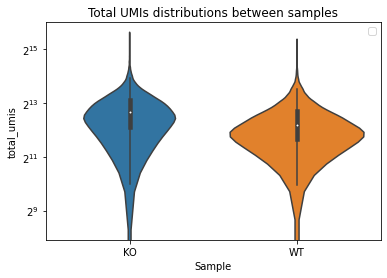

In [748]:
sb.violinplot(data=filtered_data.obs,y='total_umis',x='Sample')

plt.title("Total UMIs distributions between samples")
plt.yscale('log',base=2)
plt.legend([])

In [ ]:
mc.tl.downsample.downsample_cells(adata=filtered_data)

In [6]:
print("N UMIs downsampled:" , filtered_data.uns['downsample_samples'])
ds_mat = mc.ut.get_vo_frame(filtered_data,'downsampled')

N UMIs downsampled: 1765


In [768]:
### fixing minor issue:
ds_mat = pd.DataFrame(np.array(ds_mat),index=ds_mat.index,columns=ds_mat.columns)

**NOTE**: we regularize the modules score before log scale by adding +3

In [572]:
tds_mat = ds_mat.T
score = tds_mat.groupby(genes_to_module_dict).sum()

score_log = np.log2(3+score.T)

## adding promiscuous expression dimension

using the promiscuity metric we used at early analysis steps

Our goal here, is to build a measurement for the level of promiscuous expression observed in each cell. 
   for each metacell {looping on index number}:
       compute mean UMI per gene on ds_mat- this will give us an approximation to the expected number of UMIs we should get for each gene in the given cell state.
   
   then, for each cell:<br>
   compute *the number* of genes which:<br>
     <tab>1. exceeds 8 UMIs && exceeds 2<sup>3</sup> fold-change from the E(g)
    
**NOTE**: Since it is a heavy compuatation process, it is <u>highly</u> recommended to save the output (in pickle or some other compressed type), so it can be easily reloaded again in future processes.

In [237]:
def compute_promiscuous_expression(adata,
#                          gdata,
                        group = 'metacell',
                        downsample=True,
                        fc_thresh=8,
                        umis_thresh=8
                        ):
    group_of_cells = mc.ut.get_o_numpy(adata,group,formatter=mc.ut.groups_description)
    
    if downsample:
        if 'downsampled' in adata.layers:
            cells_umis = adata.layers['downsampled'].todense()
        else:
            _,cells_umis = mc.tl.downsample_cells(adata,inplace=False,random_seed=21)

#         mc.ut.log_get('downsampled matrix')
    else:
        cells_umis = mc.ut.get_vo_frame(adata)
    
    
    @mc.ut.timed_call("tom_modify_cell_values")
    def _compute_cell_promisc_exp(cell_idx: int):
        return _compute_prom_exp_per_cell(
            cell_idx = cell_idx,
            cells_data = cells_umis,
            group_of_cells = group_of_cells,
            fc_thresh = fc_thresh,
            umis_thresh = umis_thresh
        )
    
    results = list(mc.ut.parallel_map(_compute_cell_promisc_exp,adata.n_obs))
    
    promiscuous_mat = np.concatenate(results).reshape(adata.shape)
        
    return promiscuous_mat

In [238]:
def _compute_prom_exp_per_cell(
    *,
    cell_idx: int,
    cells_data,
    group_of_cells,
    fc_thresh,
    umis_thresh
    ):
    
    grouped_cells_mask = group_of_cells == group_of_cells[cell_idx]  # mask for curr mc cells
    grouped_cells_data = mc.ut.to_numpy_matrix(cells_data[grouped_cells_mask, :]) ## curr_mc_cells_umis
    genes_mean_data = mc.ut.mean_per(grouped_cells_data,per='column')  # mc_means_2
    adjuster = np.vectorize(lambda x: max(x,1))
    genes_mean_data_adj = adjuster(genes_mean_data)
    
    cell_data = cells_data[cell_idx,:]
    
    res = (cell_data>=umis_thresh) & ((cell_data/genes_mean_data_adj)>=fc_thresh)
    
#     assert type(cell_data)==pd.Series
    
#     fold_factors = (1+cell_data)/threshold_vals  ### computing fold factors from the mean
        
#     over_max_thresh_mask = fold_factors >= top_thresh       
#     below_min_thresh_mask = fold_factors < bottom_thresh
    
#     cell_data[over_max_thresh_mask] = new_vals_to_assign_over[over_max_thresh_mask]
#     cell_data[below_min_thresh_mask] = new_vals_to_assign_below[below_min_thresh_mask]
    
    return res


In [530]:
### reminder! check if a promiscuous expression dataframe was already obtained and saved

prom_exp_df = pd.concat([pd.DataFrame(compute_promiscuous_expression(adata=d),index=d.obs_names,columns=d.var_names) for d in [filtered_data_wt,filtered_data_ko]])

sum_of_promiscuously_exp_genes = sum(prom_exp_df.sum(axis=1)>0)
sum_of_promiscuously_exp_cells = sum(prom_exp_df.sum()>0)

In [ ]:
### saving result
pd.to_pickle(analysis_dir+'/filtered_data_prom_exp_df')

In [35]:
prom_exp_df = pd.read_pickle('./objs/pickles/filtered_data_prom_exp_df')

In [21]:
prom_exp_df_wt = prom_exp_df.loc[filtered_data_wt.obs_names]
prom_exp_df_ko

In [137]:
mc.ut.set_o_data(filtered_data_wt,name='promiscuity_idx',data=np.array(prom_exp_df_wt.sum(axis=1)))

## mTEC-II genes discretization

Our approach here is to decrease the "extra" noise in our data which stems from the variability in the expression of the mTEC-II-state-associated genes (mTEC-II gene module).

Also, we should be careful at choosing which genes faithfuly describes a cell in a "canonical" mTEC-II identity, assuming existence of such gene set. to that end, we need to examine the differential expression of feature genes and their correlation matrices in WT samples first. that should serve as the source of different cell-states and their specific/marker gene sets.

later, we can measure the infered mTEC-II genes score across all cells, order them accordingly and, given the reduction of this noisy dimension, be able to look more reliably at the interplay between different modules activity.

### removing non-mTEC cells from dataset (optional)

In [349]:
non_mtec_populations = ['jTECs','jTECs-mTEC-I_Inter','DCs','Thymocytes','cTECs']

filt_only_mtecs = mc.ut.set_o_data(filtered_data,name='is_mtec',data=np.array(~filtered_data.obs.metacell.map(metacells.obs.cell_type).isin(non_mtec_populations)))

set unnamed.obs[is_mtec]: 17376 true (94.55%) out of 18378 bools


In [353]:
filtered_data_mtecs = mc.tl.filter_data(adata=filtered_data,obs_masks=['is_mtec'])[0]

In [1601]:
score_log_mtecs = score_log.loc[filtered_data.obs.is_mtec]

### binning modules scores

default parameters settings: we will use 10 bins per module.<br>
we expect, at least for mimetic subtypes, that the top bin will contain only "true" mimetic cells with no contamination of other cell states

In [63]:
def bin_data(data,n_bins=10):
    res = pd.cut(data,bins=np.linspace(data.min(),data.max(),n_bins+1),include_lowest=True,labels=[i for i in range(1,n_bins+1)])
    return res.astype('int')

def generate_truth_profiles(data):
    f = data[data>=7].index  # masking truth profile obtaining cells
    res = ds_mat.loc[f].mean()
    return res

def get_thresh_values(data,cutoff=7):
    binned_data = bin_data(data)
    f = data[binned_data>=cutoff].index
    res = data.loc[f].min()
    return res

In [309]:
binned_module_scores = score_log.drop(columns='cell_type',errors='ignore').apply(bin_data,axis=0)

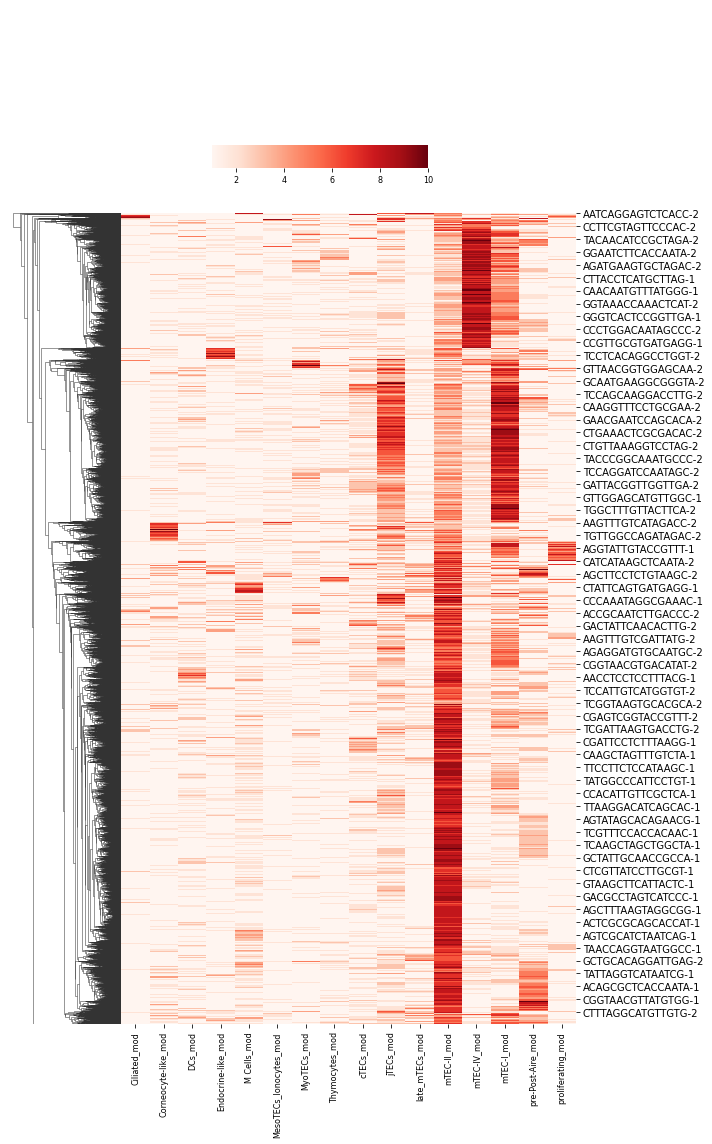

In [1659]:
sb.clustermap(binned_module_scores.astype('int'),cmap='Reds',col_cluster=False,figsize=[10,16],
              cbar_pos=(0.3, 0.85, 0.3, 0.02),cbar_kws={'orientation':'horizontal'});

### computing activation thresholds for the gene signature

In [64]:
module_thresh_values = score_log.loc[filtered_data_wt.obs_names].apply(get_thresh_values,axis=0)

### UMAP projecting metacell model - WT

In [370]:
metacells_wt = mc.pl.collect_metacells(adata=filtered_data_wt,random_seed=21)

set metacells.obs[grouped]: 93 int64s
set metacells.obs[total_umis]: 93 float64s
set metacells.layers[total_umis]: ndarray 93 X 30204 float32s
set metacells.obs[__zeros_downsample_umis]: 93 int64s
set metacells.layers[zeros]: ndarray 93 X 30204 int32s
set unnamed.obs[metacell_name]: 8695 <U8s
set metacells.var[properly_sampled_gene]: 30204 true (100%) out of 30204 bools
set metacells.var[excluded_gene]: 0 true (0%) out of 30204 bools
set metacells.var[noisy_lonely_gene]: 0 true (0%) out of 30204 bools
set metacells.var[clean_gene]: 30204 true (100%) out of 30204 bools
set metacells.var[full_gene_index]: 30204 int64s
set metacells.var[related_genes_module]: 30204 int32s
set metacells.var[rare_gene_module_0]: 17 true (0.05628%) out of 30204 bools
set metacells.var[rare_gene_module_1]: 9 true (0.0298%) out of 30204 bools
set metacells.var[rare_gene_module_2]: 11 true (0.03642%) out of 30204 bools
set metacells.var[rare_gene_module_3]: 13 true (0.04304%) out of 30204 bools
set metacells.va

In [380]:
mc.ut.set_v_data(adata=metacells_wt,data=metacells_wt.var.feature_gene>0,name='marker_gene')

set metacells.var[marker_gene]: 4049 true (13.41%) out of 30204 bools


In [381]:
mc.pl.compute_umap_by_markers(metacells_wt,min_dist=0.5,umap_k=7,random_seed=21)

set metacells.obsp[obs_balanced_ranks]: 1140 nonzero (13.18%) out of 8649 elements
set metacells.obsp[obs_pruned_ranks]: 374 nonzero (4.324%) out of 8649 elements
set metacells.obsp[obs_outgoing_weights]: 374 nonzero (4.324%) out of 8649 elements
set metacells.obsp[umap_distances]: csr_matrix 93 X 93 float32s (8556 > 0, 98.92%)
set metacells.obs[x]: 93 float32s
set metacells.obs[y]: 93 float32s


### evaluating modules activation:

The following code chunks classifies each cell according to the module scores passing the thresholds.<br>
the assignment logic allows instances with more than one active module (exception: mTEC-II gene signature).

**NOTE**:
1. mTEC-II is a "core" module which is not accepted to overlap with other modules.

2. cells which failed to pass any module activity thresholds are classified as either `mTEC-II_low` or `mTEC-II_medium` depending on their mTEC-II module activity score

In [346]:
class_module = 'mTEC-II_mod'
medium_thresh = 0.5*max(score_log.loc[filtered_data_wt.obs_names][class_module])

ignore_modules = ['mTEC-II_KO_mod']

pass_mask = score_log.drop(columns=ignore_modules) >= module_thresh_values.drop(ignore_modules)
pass_indices = np.where(pass_mask)

In [347]:
modules_activity = []
for i in range(score_log.shape[0]):
    cell_id = score_log.iloc[i].name
    modules = pass_mask.columns[pass_mask.iloc[i]]
    if class_module in modules and len(modules)>1:
        modules = modules[modules!=class_module]
    for mod in modules:
#     for entry_idx, module_idx in zip(*pass_indices):
#     module = score_log.drop(columns=ignore_modules).columns[module_idx]
        modules_activity.append({'cell_id': cell_id, 'Module': mod})

In [348]:
not_pass_indices = np.where(~pass_mask.any(axis=1))[0]
for entry_idx in not_pass_indices:
    cell_id = score_log.iloc[entry_idx].name
    module = 'mTEC-II'
    score = score_log.iloc[entry_idx][class_module]
    if score >= medium_thresh:
        modules_activity.append({'cell_id': cell_id, 'Module': f'{module}_medium'})
    else: 
        modules_activity.append({'cell_id': cell_id, 'Module': f'{module}_low'})

In [350]:
modules_activity = pd.DataFrame(modules_activity).set_index('cell_id')

In [386]:
modules_activity['Module'].replace({"mTEC-II_mod":"mTEC-II_high"},inplace=True)

In [358]:
## merging single cells genotype data and gene-module scores
modules_activity = modules_activity.join([filtered_data.obs.Sample]).join(score_log)

In [374]:
### classifying metacells into cell-types (based on cells majority vote):
mc_annots = []

for metac in range(metacells_wt.n_obs):
    cells_in_mc = filtered_data_wt.obs_names[filtered_data_wt.obs.metacell==metac]
    maj_type = list(modules_activity.loc[cells_in_mc]['Module'].value_counts().index)[0]
    mc_annots.append(maj_type)

In [375]:
mc.ut.set_o_data(adata=metacells_wt,data=mc_annots,name='ctype')

set metacells.obs[ctype]: 93 strs


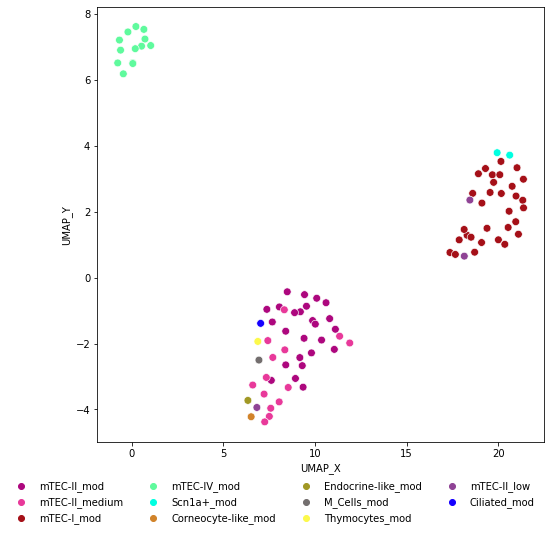

In [384]:
### Supplemental Figure 1b

plt.figure(figsize=(8,8))

sb.scatterplot(x=metacells_wt.obs['umap_x'],
                y=metacells_wt.obs['umap_y'],hue=metacells_wt.obs['ctype'],palette=modules_color_dict,s=60)
plt.xlabel("UMAP_X");plt.ylabel("UMAP_Y")
plt.legend(bbox_to_anchor = (1,-0.07),ncol=4,frameon=False)

plt.savefig(fig_dir+'/Supp_fig_1b.png')

### rerun on WT cells only

In [2210]:
wt_binned_module_scores = score_log.drop(columns='cell_type',errors='ignore').loc[filtered_data_wt.obs_names].apply(bin_data)

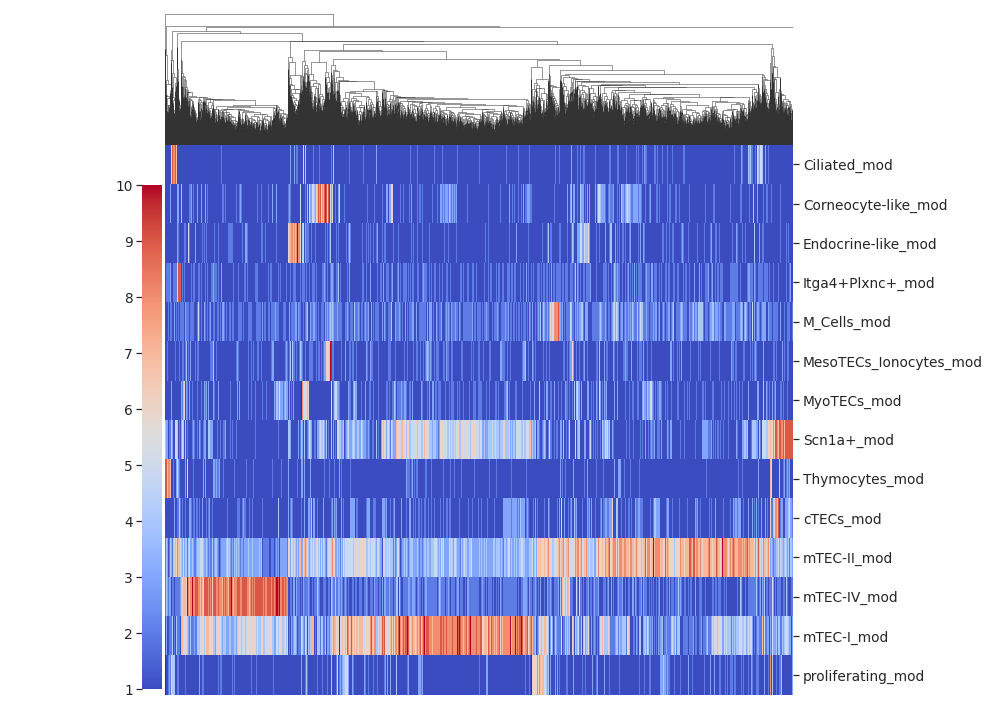

In [2213]:
### Supplemental Figure 1c

sb.set(font_scale=1.25)
cm=sb.clustermap(wt_binned_module_scores[[i for i in wt_binned_module_scores.columns if i!='mTEC-II_KO_mod']].astype('int').T,
                 cmap='coolwarm',row_cluster=False,figsize=[14,10],
              xticklabels=False,facecolor='white',
             cbar_pos=(0.15, 0.03, 0.02, 0.7)
             )

# cm.ax_heatmap.set_yticks(size=12)
cm.ax_cbar.yaxis.set_ticks_position('left')

sb.set(font_scale=1)

plt.savefig(fig_dir+'/Supp_fig_1c.png')

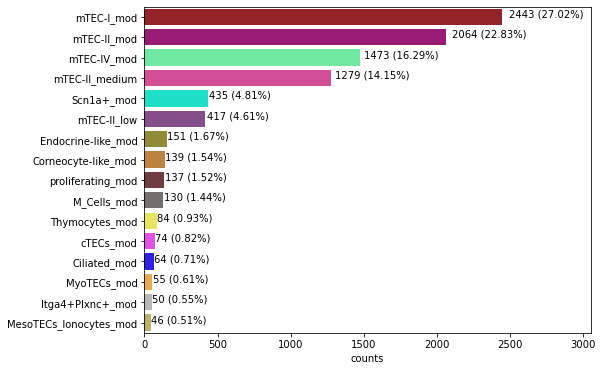

In [373]:
### Supplemental Figure 1d

sup_fig1d_df = pd.DataFrame({"freq":(modules_activity.loc[filtered_data_wt.obs_names].Module.value_counts(normalize=True)*100).round(2),
                             "counts":(modules_activity.loc[filtered_data_wt.obs_names].Module.value_counts())})


plt.figure(figsize=(8,6))
sb.barplot(data=sup_fig1d_df.reset_index(),x='counts',y='index',color='index',palette=modules_color_dict)
plt.xlim(0,sup_fig1d_df.counts.max()*1.25)
plt.ylabel(None)

for level,mod in enumerate(sup_fig1d_df.index):
    plt.text(x=sup_fig1d_df.loc[mod,'counts']*1.02,y=level,s=f"{sup_fig1d_df.loc[mod,'counts']} ({sup_fig1d_df.loc[mod,'freq']}%)")

plt.savefig(fig_dir+'/Supp_fig_1d.png')

In [573]:
## subsetting only Aire WT cells
wt_cells_modules_score = score_log.loc[filtered_data_wt.obs_names]

### Fig 1A - Gene-Gene Correlation of modules genes across WT cells only

In [567]:
selected_genes = gene_modules.gene[~gene_modules.module.isin(ignore_modules)]

#### in cells resolution

In [568]:
# modules_gene_gene_cor = mc.ut.corrcoef(ds_mat_wt_modules_genes,per='column',reproducible=True)
modules_gene_gene_cor = ds_mat.loc[filtered_data_wt.obs_names,selected_genes].corr()
np.fill_diagonal(modules_gene_gene_cor.values,np.nan)
modules_gene_gene_cor = pd.DataFrame(modules_gene_gene_cor,index=selected_genes,columns=selected_genes)

In [569]:
row_cols = [modules_color_dict[genes_to_module_dict[k]] for k in selected_genes if genes_to_module_dict[k]!='mTEC-II_KO_mod']

In [570]:
selected_genes_to_show = ['Agbl4','Dnah12','Spag16','Flg','Krt10','Prss16','Spink5','Plxnc1','Stxbp5l','Car8','Scn1a','Gpc5',
                          'Saa1','Apoa4','Cr2','Ccl20','Ccl21a','Lifr','Aire','Mctp1','St18','Pou2f3','Meg3','Ttn','Rgs7','Mir100hg',
                          'Alox5','Mki67','Top2a','Ccna2','Hmgb2','Cd3e','Skap1','Gpm6a','Tnfrsf11b','Mybpc1','Cd74','Sirt1',]

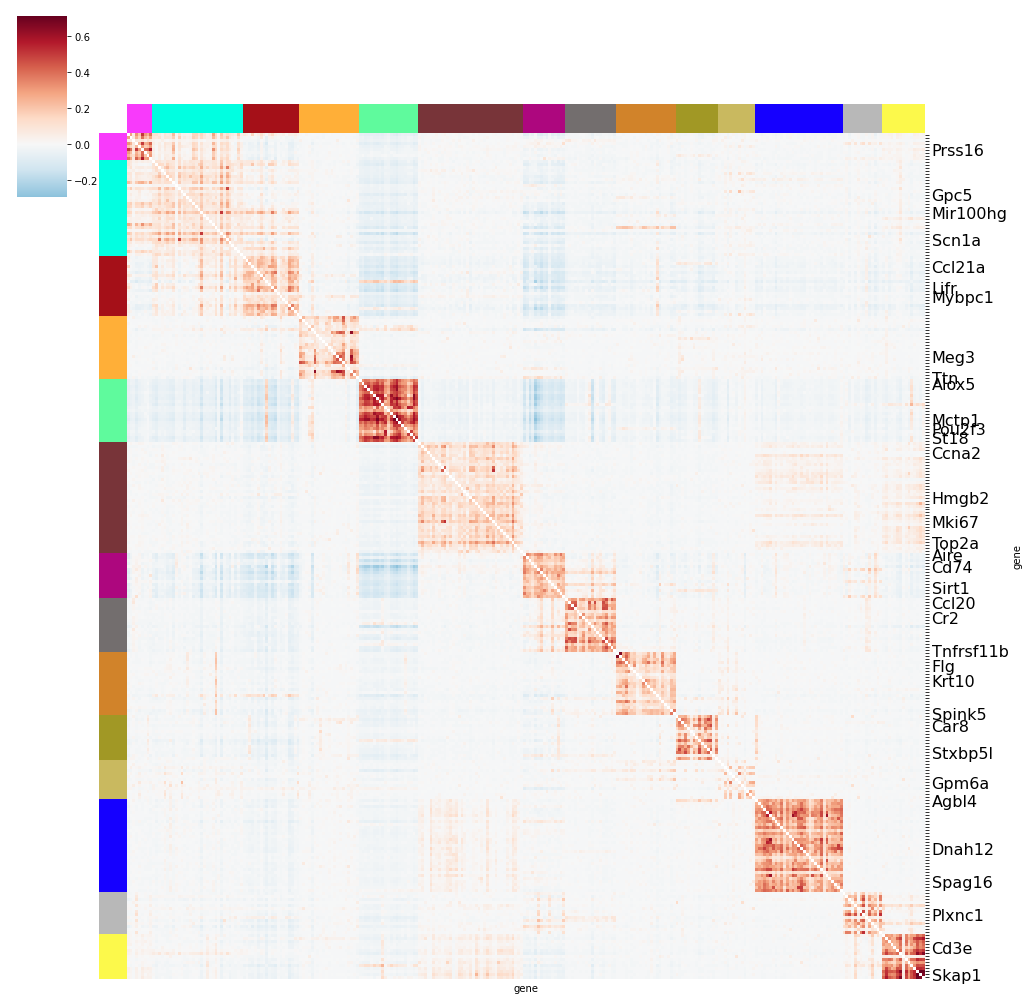

In [571]:
### Figure 1a

cm = sb.clustermap(modules_gene_gene_cor,cmap='RdBu_r',row_cluster=False,col_cluster=False,
              row_colors=row_cols,col_colors=row_cols,figsize=[14,14],center=0,dendrogram_ratio=0.1,
              xticklabels = False , yticklabels=[x if x in selected_genes_to_show else None for x in modules_gene_gene_cor.index],
              )

cm.ax_heatmap.set_yticklabels(labels=cm.ax_heatmap.get_ymajorticklabels(),fontsize=16);

# plt.show()

plt.savefig(fig_dir+'/Fig_1a.png')

#### in metacells resolution

In [749]:
### metacell aggregated normalized expression per gene
mc_gene_exp = ds_mat.loc[filtered_data_wt.obs_names,gene_modules.gene].groupby(filtered_data_wt.obs.metacell).sum()

### computing correlation coefficients for genes:
modules_gene_gene_cor_mc = mc.ut.corrcoef(mc_gene_exp,per='column',reproducible=True)
np.fill_diagonal(modules_gene_gene_cor_mc,np.nan)
modules_gene_gene_cor_mc = pd.DataFrame(modules_gene_gene_cor_mc,index=mc_gene_exp.columns,columns=mc_gene_exp.columns)

modules_gene_gene_cor_mc = modules_gene_gene_cor_mc.loc[gene_modules.gene[gene_modules.module!='mTEC-II_KO_mod'],gene_modules.gene[gene_modules.module!='mTEC-II_KO_mod']]

In [731]:
row_cols = list(gene_modules.module[gene_modules.module!='mTEC-II_KO_mod'].map(modules_color_dict))

# row_cols = [cell_type_color_dict[genes_to_module_dict[k].replace('_mod','')] for k in selected_genes]

In [743]:
modules_gene_gene_cor_mc = pd.DataFrame(np.fill_diagonal(np.array(modules_gene_gene_cor_mc),np.nan),index=modules_gene_gene_cor_mc.index,columns=modules_gene_gene_cor_mc.columns)

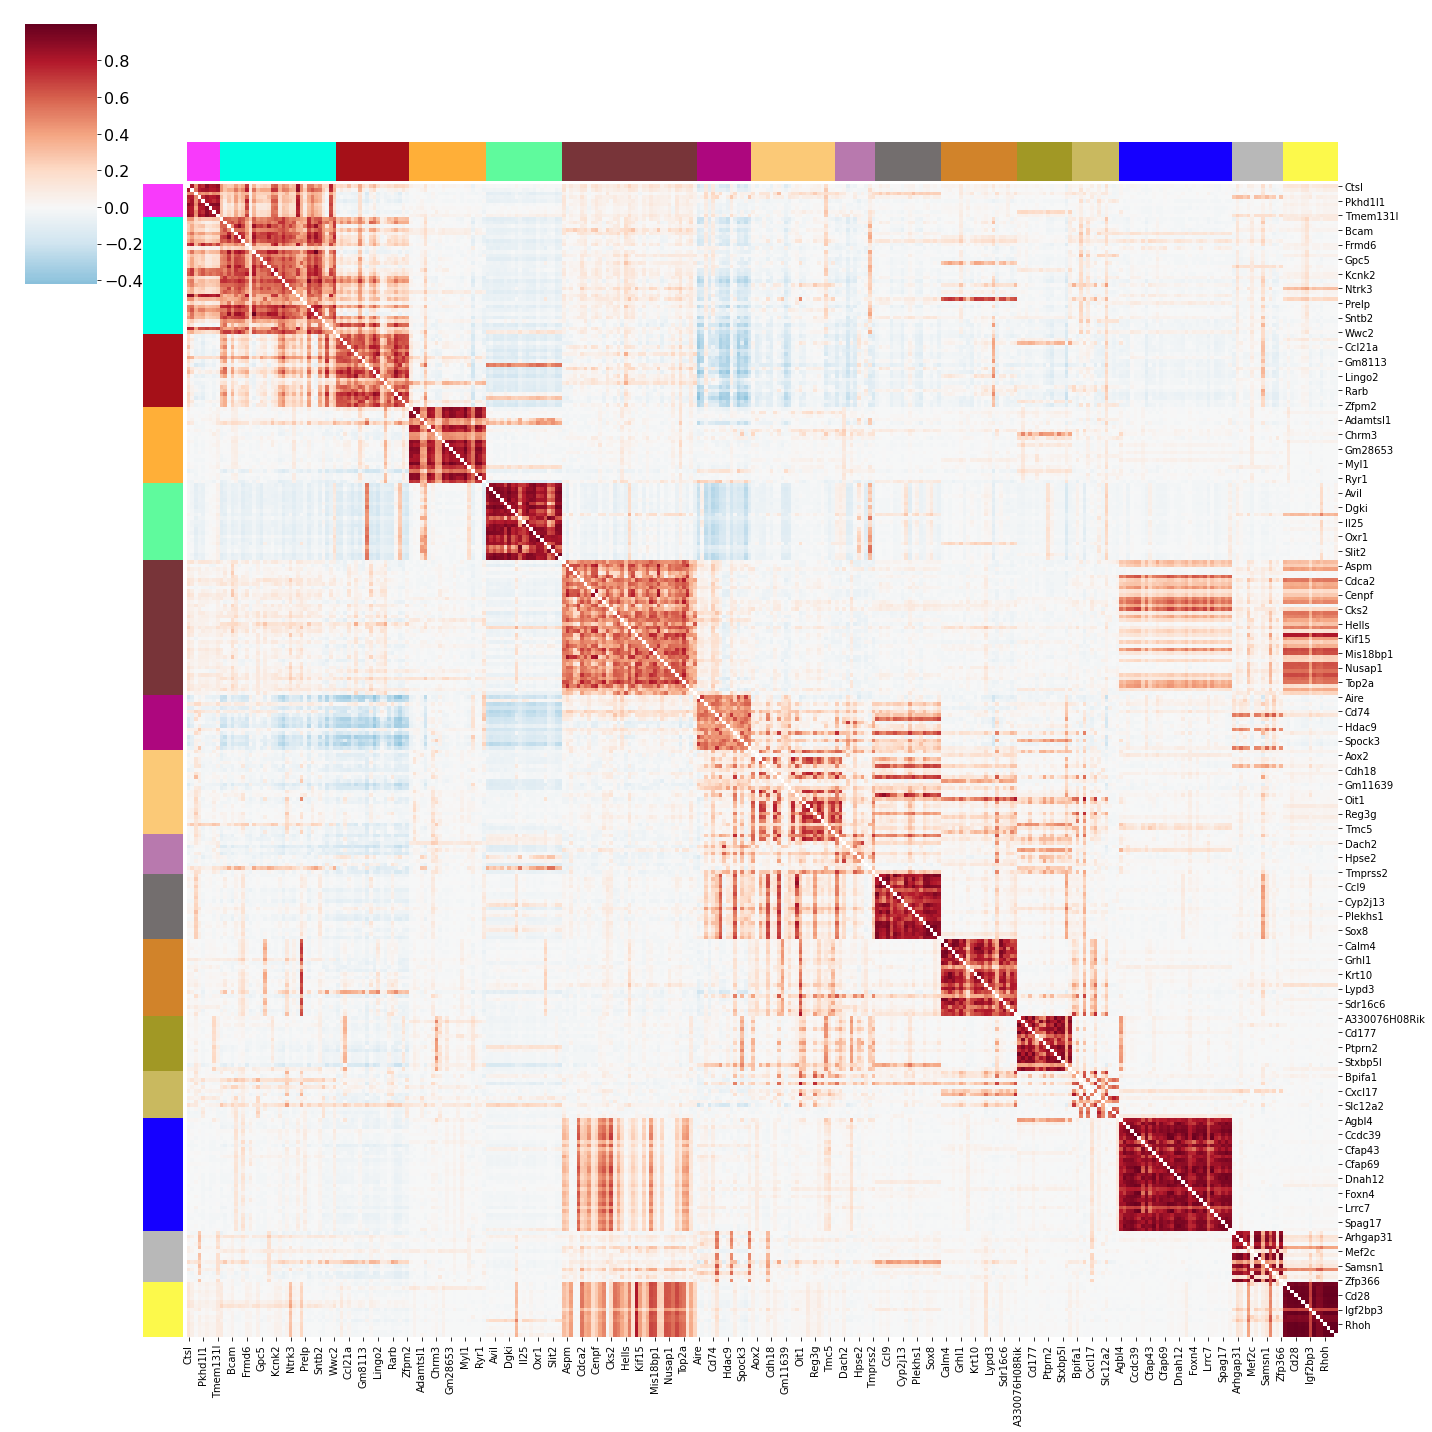

In [764]:
cm = sb.clustermap(modules_gene_gene_cor_mc,cmap='RdBu_r',row_colors=row_cols,col_colors=row_cols,figsize=[20,20],center=0,row_cluster=False,col_cluster=False,dendrogram_ratio=0.1)
cm.ax_cbar.tick_params(labelsize=16)

## examine TFs correlation

In [542]:
tfs = pd.read_table('/home/tomgo/raid/proj/mtec_populations/data/genes_data/tfs.txt',header=None)[0]

In [543]:
tfs = tfs.apply(lambda x: str.capitalize(x))

In [545]:
cat_mat_for_cor = pd.concat([score_log[gene_modules.module.unique()],ds_mat[tfs[tfs.isin(ds_mat.columns)].values]],axis=1)

In [548]:
cor_res = mc.ut.corrcoef(cat_mat_for_cor,reproducible=True,per='column')

In [549]:
np.fill_diagonal(a=cor_res,val=np.nan)
cor_res = pd.DataFrame(cor_res,index=cat_mat_for_cor.columns,columns=cat_mat_for_cor.columns)

In [552]:
n_modules = len(gene_modules.module.unique())
fixed_cor_res = cor_res.iloc[:n_modules,(n_modules+1):]

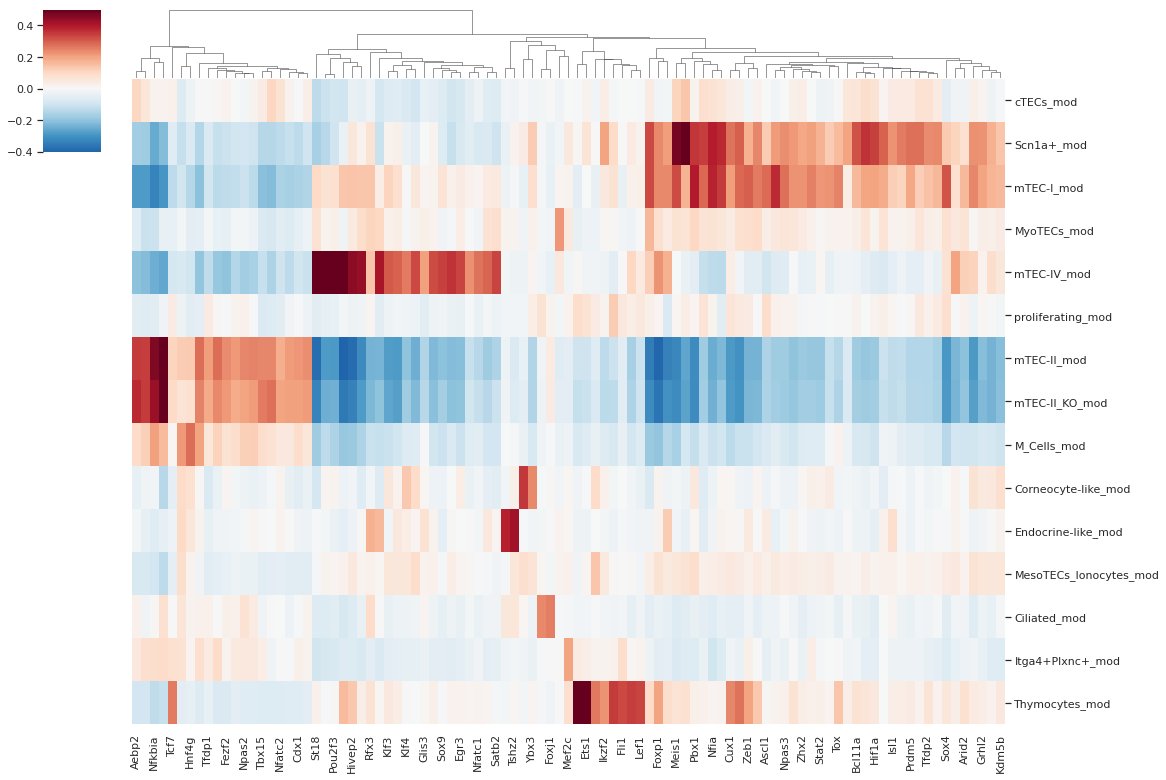

In [598]:
TF_max_correlation_cutoff = 0.2

tf_cm = sb.clustermap(fixed_cor_res.loc[:,np.abs(fixed_cor_res).max()>TF_max_correlation_cutoff],
                      cmap='RdBu_r',center=0,row_cluster=False,figsize=(16,11),vmax=0.5,dendrogram_ratio=0.1,
                      cbar_kws={'ticklocation':'left'})

## making Final figures

### WT - Figure 1

#### Fig 1b - mTEC-IV distribution over cells

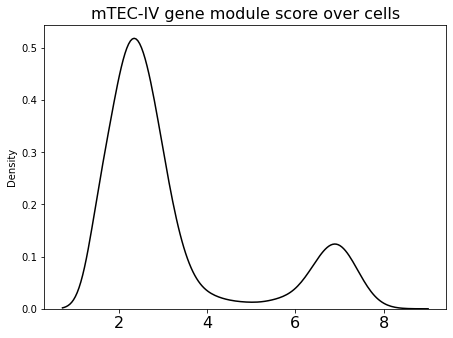

In [546]:
### Figure 1b
plt.figure(figsize=(6.4,4.8))
sb.kdeplot(wt_cells_modules_score['mTEC-IV_mod'].to_numpy(),color='k')
plt.xlabel(''); plt.xticks(size=16)
plt.title('mTEC-IV gene module score over cells',size=16)

plt.tight_layout()

plt.savefig(fig_dir+'/Fig_1b.png')

#### Fig 1c - anti-mTEC-IV genes score vs. mTEC-IV genes score scatter

highlighting Anti-mTEC-IV genes:
- we compute the genes enrichment in all metacells, and then by using the mask

In [ ]:
metacells_wt_umis = sc_umis.loc[filtered_data_wt.obs_names].groupby(filtered_data_wt.obs.metacell).sum()

In [65]:
gene_gene_correlation = mc.ut.corrcoef(metacells_wt_umis,per='column',reproducible=True)

In [66]:
gg_correlation_mtec4_genes = gene_gene_correlation[metacells_wt_umis.columns.isin(gene_modules.gene[gene_modules.module=='mTEC-IV_mod']),:]

In [67]:
### for each gene in the mTEC-IV module - get the top-5 most uncorrelated genes
### *run intersection (unique) to avoid duplications

anti_genes_to_mtec4 = list(filtered_data_wt.var_names[np.unique(pd.DataFrame(gg_correlation_mtec4_genes).apply(lambda x: np.argsort(x)[:5],axis=1))])

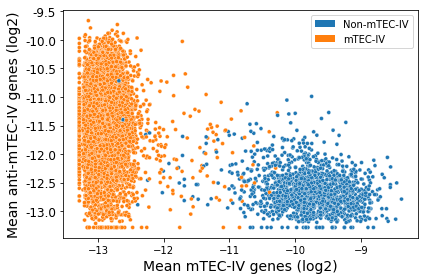

In [126]:
### Figure 1c

# plt.figure(figsize=(10,8))
### plotting
# x=np.log2(1e-4+sc_umis_fracs.loc[filtered_data_wt.obs_names][gene_modules.gene[gene_modules.module=='mTEC-IV_mod']]).mean(axis=1)
# y=np.log2(1e-4+sc_umis_fracs.loc[filtered_data_wt.obs_names][anti_genes_to_mtec4]).mean(axis=1)

sb.scatterplot(x=x,y=y,hue=score_log.loc[filtered_data_wt.obs_names]['mTEC-IV_mod']>=module_thresh_values['mTEC-IV_mod'],s=16,palette=sb_colors[:2][::-1])

plt.gca().yaxis.set_major_formatter(lambda x,pos: f"%.1f" % x)
plt.yticks(fontsize=12)
plt.xlabel('Mean mTEC-IV genes (log2)',size=14); plt.ylabel('Mean anti-mTEC-IV genes (log2)',size=14)

plt.legend(handles = [Patch(facecolor=sb_colors[i]) for i in range(2)],labels=['Non-mTEC-IV','mTEC-IV'])
plt.tight_layout()

## SAVING
plt.savefig(fig_dir+'/Supp_fig_1c.png')

Text(0.5, 0, 'mTEC-IV gene signature')

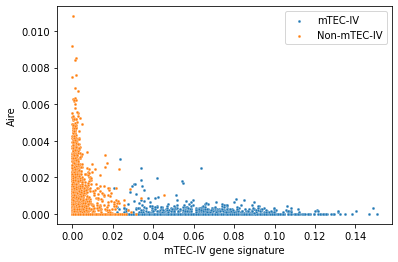

In [727]:
### mTEC-IV program vs. Aire expression

## Non-mTEC-IV
# x1 = sc_umis_fracs.loc[filtered_data_wt.obs_names].loc[wt_cells_modules_score['mTEC-IV_mod']<module_thresh_values['mTEC-IV_mod']][gene_modules.gene[gene_modules.module=='mTEC-IV_mod']].sum(axis=1)
# y1 = sc_umis_fracs.loc[filtered_data_wt.obs_names].loc[wt_cells_modules_score['mTEC-IV_mod']<module_thresh_values['mTEC-IV_mod']]['Aire']

# x2 = sc_umis_fracs.loc[filtered_data_wt.obs_names].loc[wt_cells_modules_score['mTEC-IV_mod']>=module_thresh_values['mTEC-IV_mod']][gene_modules.gene[gene_modules.module=='mTEC-IV_mod']].sum(axis=1)
# y2 = sc_umis_fracs.loc[filtered_data_wt.obs_names].loc[wt_cells_modules_score['mTEC-IV_mod']>=module_thresh_values['mTEC-IV_mod']]['Aire']

sb.scatterplot(x=x2,y=y2,label='mTEC-IV',s=8)
sb.scatterplot(x=x1,y=y1,label='Non-mTEC-IV',s=8)
plt.xlabel("mTEC-IV gene signature")

#### Supp Fig 2a - barplot of activitation frequencies of all other gene modules on IV<sup>+</sup> vs. IV<sup>-</sup>

In [423]:
x = wt_cells_modules_score
x['subtype'] = ['mTEC-IV' if t>=module_thresh_values['mTEC-IV_mod'] else 'Non-mTEC-IV' for t in x['mTEC-IV_mod']]

In [396]:
subsets_to_ignore = [s+'_mod' for s in ['mTEC-II_KO', 'Thymocytes', 'proliferating', 'mTEC-IV']]

In [424]:
x = pd.DataFrame({"Non-mTEC-IV":(x[x['subtype']=='Non-mTEC-IV'][module_thresh_values.index]>=module_thresh_values).sum()/sum(x.subtype=='Non-mTEC-IV'),
              "mTEC-IV":(x[x['subtype']=='mTEC-IV'][module_thresh_values.index]>=module_thresh_values).sum()/sum(x.subtype=='mTEC-IV')})

x_m = x.reset_index().melt(id_vars=['index'])

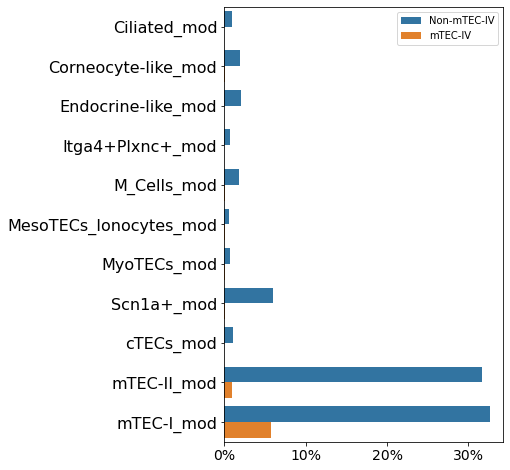

In [425]:
### Supplemental Figure 2a

plt.figure(figsize=(5,8))
s= sb.barplot(data=x_m.query("index not in @subsets_to_ignore"),y='index',x='value',hue='variable')
plt.ylabel(None);plt.xlabel(None);

# plt.xlim(0,0.1)

plt.tick_params(labelsize=16)
s.set_xticklabels(['%.f%%' % (i*100) for i in s.get_xticks()],size=14)
plt.legend(title=None)

plt.savefig(fig_dir+'/Supp_fig_2a.png')

#### Supp Fig 1e - Marker heat map on mTEC-IV<sup>+</sup> cells only

We will show the differential markers within the mTEC-IV sub-type over metacells

I use metacell from a new model, which I generate over WT cells only from the filtered data

In [911]:
## we distinguish the cells as mTEC-IV-positive or -negative based on the module score thresholds.
mtec4_cells = wt_cells_modules_score.loc[wt_cells_modules_score['mTEC-IV_mod']>=module_thresh_values['mTEC-IV_mod']].index

In [940]:
intra_mtec4_diff_exp_genes = ['Dnah5','Agbl1','Adgrg6','Malrd1',
                              'Kcnh7','Nrxn3','Rgs21','Dcc','Adamtsl1','Gm12153','Gm20125','Grin2a',
                              'Scn2a','Cdh13','Hs6st3','Mapk10']

In [942]:
ds_mat_wt_mtec4 = ds_mat.loc[mtec4_cells]
ds_mat_wt_mtec4_grped = ds_mat_wt_mtec4.groupby(filtered_data_wt.obs.loc[mtec4_cells,'metacell']).sum()

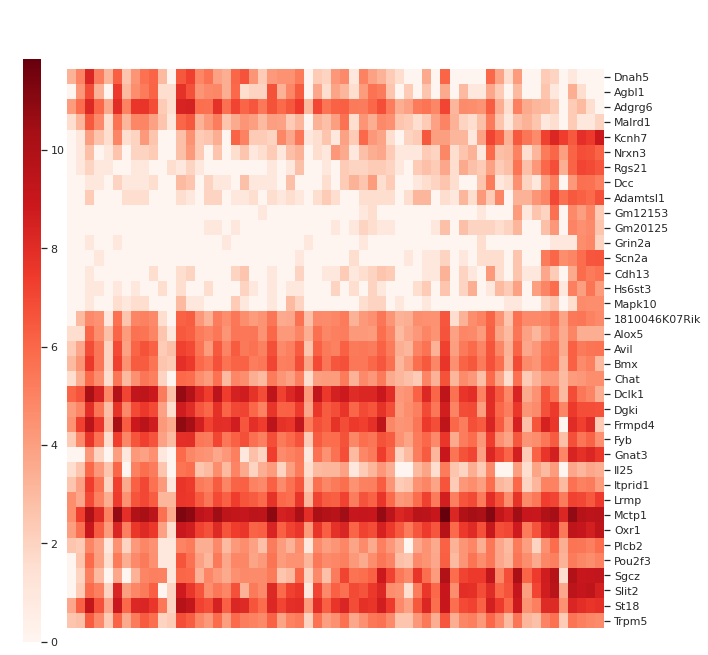

In [956]:
### Supplemental Figure 1e

### we transposee to have the gene names as rows
log_ds_mat_mtec4 = np.log2(1+ds_mat_wt_mtec4_grped.T)

# rows_slanter_order,col_slanter_order = get_slatner_order(log_ds_mat_mtec4.values)

sb.clustermap(log_ds_mat_mtec4.loc[intra_mtec4_diff_exp_genes+list(gene_modules.gene[gene_modules.module=='mTEC-IV_mod'])].iloc[:,col_slanter_order],
              cmap='Reds',xticklabels=False,row_cluster=False,col_cluster=False,yticklabels=True,
              dendrogram_ratio=0.1,figsize=[10,9],cbar_pos=(0.04, 0, 0.025, 0.9))

plt.savefig(fig_dir+'/Supp_fig_1e.png')

#### Evaluating frequency of Aire expression in different cell-types

In [428]:
d=(sc_umis.loc[modules_activity.index,'Aire']>0).groupby(modules_activity['Module']).value_counts(normalize=True).to_frame()  #apply(lambda x: x.value_counts())

In [430]:
d=pd.DataFrame({"grp":d.index.get_level_values(0),
             "exp":d.index.get_level_values(1),
             "value":d['Aire']})

In [431]:
d['value2']=d['value']*100

Text(0.5, 1.0, '%s cells with Aire transcripts sampled')

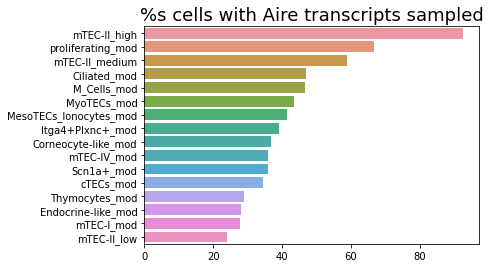

In [432]:
p1=sb.barplot(d.query("exp==True").sort_values('value2',ascending=False),y='grp',x='value2')
plt.ylabel(None);plt.xlabel(None)
plt.title("%s cells with Aire transcripts sampled",size=18)
# plt.legend().remove()

<AxesSubplot:xlabel='Aire', ylabel='Proportion'>

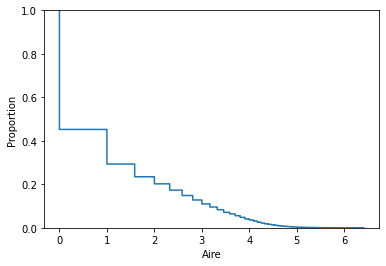

In [1556]:
sb.ecdfplot(np.log2(1+sc_umis.loc[filtered_data.obs.Sample=='WT','Aire']),complementary=True)

#### Fig 1d -  BAR PLOT OF mTEC-I VS. mTEC-II SIGNATURES CO-ACTIVATION OF MIMETIC MODULES

In [574]:
df = wt_cells_modules_score
barplot_df = pd.DataFrame({'module':gene_modules.module.unique()})

for mod in barplot_df.module:
    col=mod.replace('_mod','')
    copy_df = df.copy()
    copy_df[col] = df[mod]>=module_thresh_values[mod]
    x=(copy_df.drop(columns=col)>=module_thresh_values).assign(**{col:copy_df[col]}).astype(float).groupby(col).mean()
    x_m = x.reset_index(inplace=False).melt(id_vars=[col],var_name='module',value_name=col+"_")
    x_m = x_m[x_m[col]==1]

    # optional:
    # x_m.loc[x_m['variable']==mod,'value']=0
    barplot_df = barplot_df.merge(x_m.iloc[:,-2:],on='module')
    barplot_df.columns=barplot_df.columns.map(lambda x: x.rstrip('_'))
    barplot_df.rename(columns={"Ciliate":"Ciliated"},inplace=True)

subsets_to_ignore = ['mTEC-I','mTEC-II','mTEC-II_KO','Thymocytes','proliferating','mTEC-IV']
barplot_df_final = barplot_df[barplot_df.columns[~barplot_df.columns.isin(subsets_to_ignore)]].set_index('module').loc[['mTEC-I_mod','mTEC-II_mod']].T.sort_values('mTEC-II_mod').reset_index().melt(id_vars=['index'])

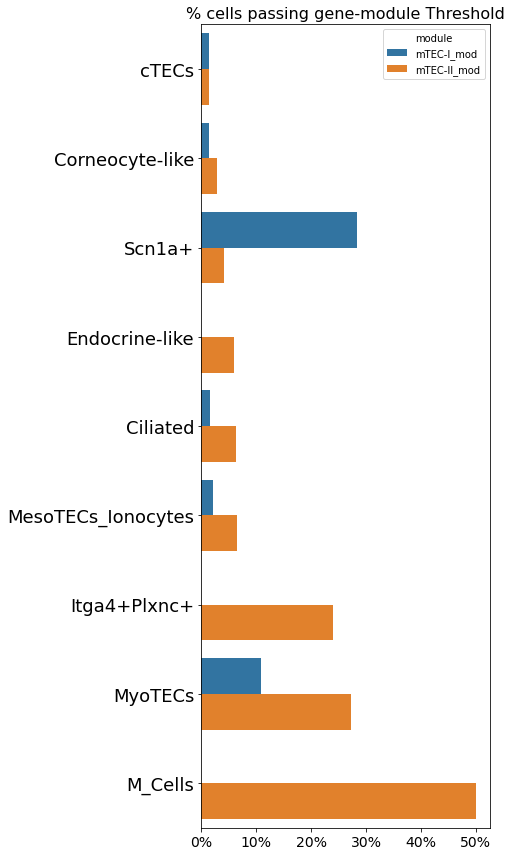

In [575]:
### Figure 1d

plt.figure(figsize=(7,12));

s=sb.barplot(data=barplot_df_final,x='value',y='index',hue='module')
plt.ylabel(None); plt.xlabel(None); plt.title('% cells passing gene-module Threshold',size=16);
s.set_xticklabels(['%.f%%' % (i*100) for i in s.get_xticks()],size=14)
plt.yticks(size=18);
plt.tight_layout()

plt.savefig(fig_dir+'/Fig_1d.png')

#### Fig 1e - SCATTER PLOT OF mTEC-I VS. mTEC-II SIGNATURES IN CELLS & proliferating TECs

<Figure size 360x360 with 0 Axes>

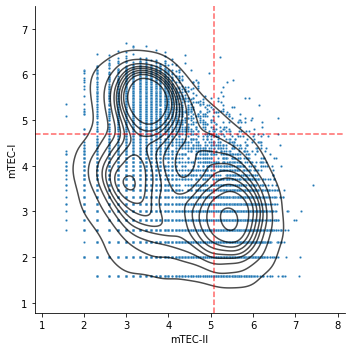

In [603]:
### Figure 1e
plt.figure(figsize=(5,5))
### SCATTER PLOT OF mTEC-I VS. mTEC-II SIGNATURES IN CELLS

sb.displot(x=wt_cells_modules_score['mTEC-II_mod'],
              y=wt_cells_modules_score['mTEC-I_mod'],kind='kde',color='black',alpha=0.7)

sb.scatterplot(x=wt_cells_modules_score['mTEC-II_mod'],y=wt_cells_modules_score['mTEC-I_mod'],s=5)
plt.ylabel('mTEC-I'); plt.xlabel('mTEC-II');

plt.axhline(y=module_thresh_values['mTEC-I_mod'],linestyle='--',color='red',alpha=0.6)
plt.axvline(x=module_thresh_values['mTEC-II_mod'],linestyle='--',color='red',alpha=0.6)

plt.savefig(fig_dir+'/Fig_1e.png')

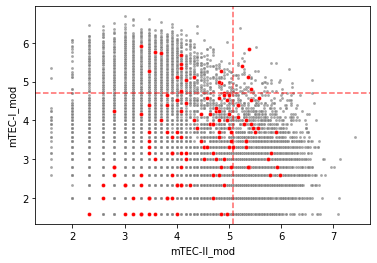

In [604]:
### first layer - cells that don't pass the proliferating threshold
prolif_active_cells = score_log.loc[filtered_data_wt.obs_names]['proliferating_mod']>=module_thresh_values['proliferating_mod']

sb.scatterplot(x=wt_cells_modules_score.loc[~prolif_active_cells,'mTEC-II_mod'],
              y=wt_cells_modules_score.loc[~prolif_active_cells,'mTEC-I_mod'],s=9,color='gray',alpha=0.7)

### second layer - cells that  pass the proliferating threshold
sb.scatterplot(x=wt_cells_modules_score.loc[prolif_active_cells,'mTEC-II_mod'],
              y=wt_cells_modules_score.loc[prolif_active_cells,'mTEC-I_mod'],s=16,color='red')

plt.axhline(y=module_thresh_values['mTEC-I_mod'],linestyle='--',color='red',alpha=0.6)
plt.axvline(x=module_thresh_values['mTEC-II_mod'],linestyle='--',color='red',alpha=0.6)

plt.savefig(fig_dir+'/Fig_1e_2.png')

#### Enrichment of UMIs from cells with active proliferating signature

Text(0.5, 1.0, 'Proportion of UMIs from proliferating-active cells')

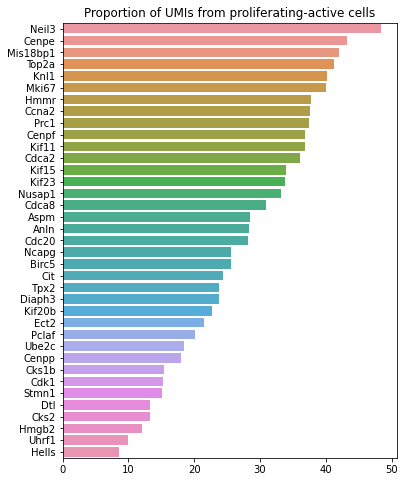

In [749]:
mod ='proliferating_mod'

br_prof_genes_prof_cells = ds_mat.loc[filtered_data_wt.obs_names].loc[wt_cells_modules_score[mod]>=module_thresh_values[mod],gene_modules.gene[gene_modules.module==mod]].sum()
br_prof_genes_all_cells = ds_mat.loc[filtered_data_wt.obs_names,gene_modules.gene[gene_modules.module==mod]].sum()

br_prof_genes_ratio = (br_prof_genes_prof_cells/br_prof_genes_all_cells)*100

#------------------------

plt.figure(figsize=(6,8))
sb.barplot(pd.DataFrame({'gene':br_prof_genes_ratio.index,'enr':br_prof_genes_ratio}).sort_values('enr',ascending=False),y='gene',x='enr')
plt.ylabel(None);plt.xlabel(None)
plt.title("Proportion of UMIs from proliferating-active cells")

#### Fig 1f - moving averages activation of gene modules as a function of mTEC-II score ranked

In [1740]:
sb.reset_orig()

In [605]:
mov_avg_df = wt_cells_modules_score.sort_values('mTEC-II_mod')

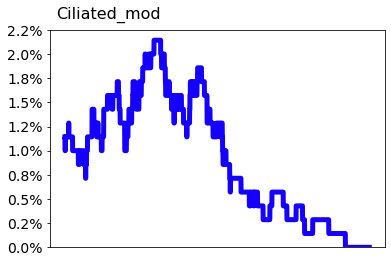

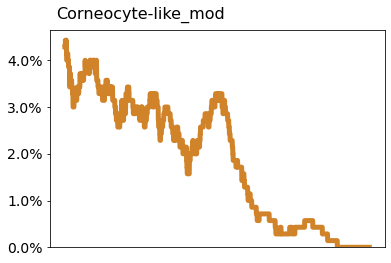

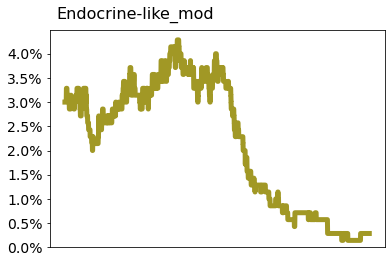

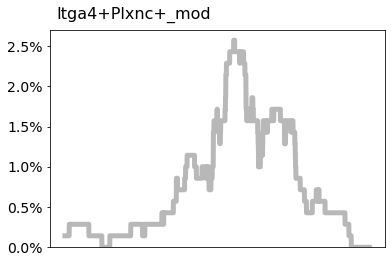

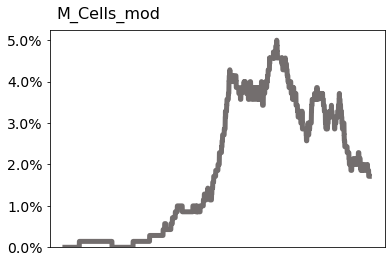

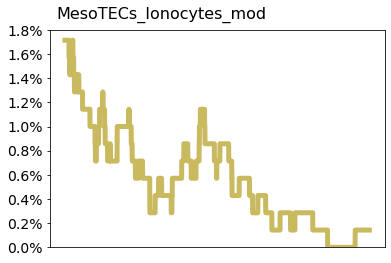

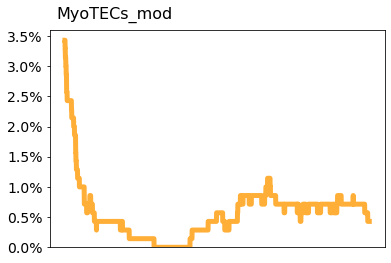

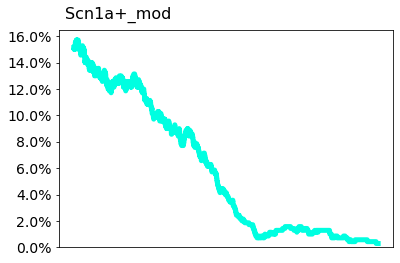

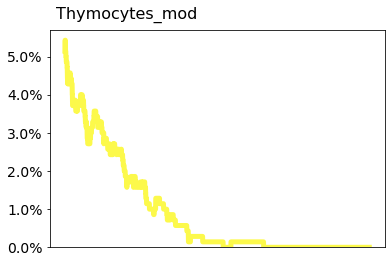

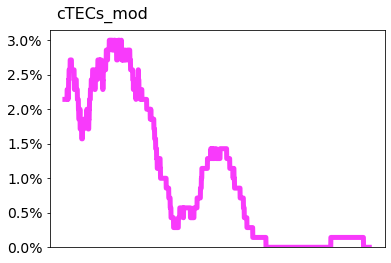

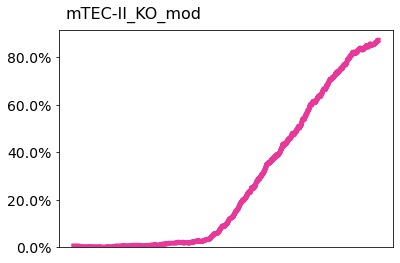

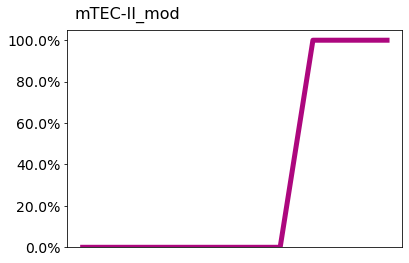

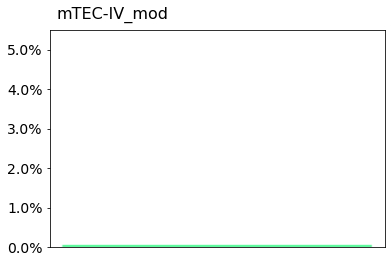

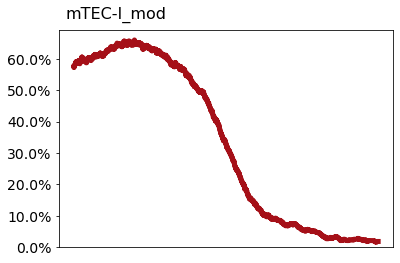

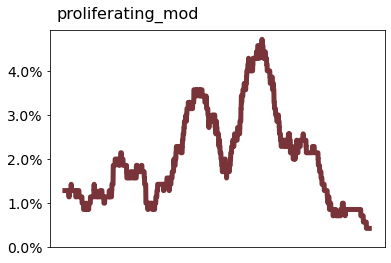

In [626]:
## creating sub-directory for figures:
if not os.path.exists(fig_dir+'Fig1_Moving_Averages'):
    os.mkdir(fig_dir+'Fig1_Moving_Averages')

## subset out mtec4 cells
mov_avg_df = mov_avg_df[mov_avg_df['mTEC-IV_mod']<module_thresh_values['mTEC-IV_mod']]

## order x-axis by mTEC-II signature
mov_avg_df['cell_idx'] = [i for i in range(len(mov_avg_df))]
mods=np.unique(gene_modules.module)

w_s = 700 # window size
for i in range(len(mods)):
    mod = mods[i]

    s=sb.lineplot(x=mov_avg_df.cell_idx,y=mov_avg_df[mod].rolling(w_s,axis=0).apply(lambda x: sum(x>=module_thresh_values[mod])/w_s),color=modules_color_dict[mod],linewidth=5)
    ## forcing figures to start from 0 in y-axis
    bottom,top = plt.ylim()
    plt.ylim(0,top)
    ### displaying y-axis in percentages
    s.set_yticklabels(['%.1f%%' % (i*100) for i in s.get_yticks()],size=14)
    
    ## cleaning figure axis titles
    plt.ylabel(None); plt.xlabel(None); plt.xticks([]);
    
    plt.text(0.02,1.05,s=mod,transform=s.transAxes,size=16)
    
    ## saving sub-figure
    
    plt.savefig(fig_dir+f'Fig1_Moving_Averages/{mod}.png')
    
    plt.clf()

#### Fig 1g-i - type-1a & type-1b expression as a function of mTEC-II score

The promiscuity index used thus far did not take into account the basal expression of the promiscuously expressed genes - so the index was composed of both "True" promiscuous abnormal expression and bursty ones

here we separate between the 2 categories

In [61]:
genes_basal_exp = (sc_umis.loc[filtered_data_wt.obs_names]>0).sum()/filtered_data_wt.n_obs

In [695]:
### choosing the cutoffs to distinguish between "True" promiscuous expression, i.e. very large UMI count in 
### a cell for genes which is expressed in less than X% of the data.
### and the "bursty" expressison which demonstrates sudden high expression of a gene which is generally expressed.

true_prom_cutoff = 0.05
bursty_exp_cutoff = 0.2

true_promiscuity_idx_wt = prom_exp_df.loc[filtered_data_wt.obs_names,genes_basal_exp<true_prom_cutoff].sum(axis=1)
basal_promiscuity_idx_wt = prom_exp_df.loc[filtered_data_wt.obs_names,genes_basal_exp>=bursty_exp_cutoff].sum(axis=1)

true_promiscuity_idx_ko = prom_exp_df.loc[filtered_data_ko.obs_names,genes_basal_exp<true_prom_cutoff].sum(axis=1)
basal_promiscuity_idx_ko = prom_exp_df.loc[filtered_data_ko.obs_names,genes_basal_exp>=bursty_exp_cutoff].sum(axis=1)

##### Figure 1g

Select 100 cells, show type-1a promiscuous genes.<br>
At the bottom, show some type-1b (bursty) genes

In [633]:
selection_of_cells = true_promiscuity_idx_wt[true_promiscuity_idx_wt>0].sample(100).index
selection_of_genes = prom_exp_df.columns[(prom_exp_df.loc[selection_of_cells].max()>0)]

In [635]:
sampled_prom_genes = genes_basal_exp[selection_of_genes][genes_basal_exp[selection_of_genes]<0.03].sample(10).index
sampled_bursty_genes = genes_basal_exp[selection_of_genes][genes_basal_exp[selection_of_genes]>0.2].sample(10).index

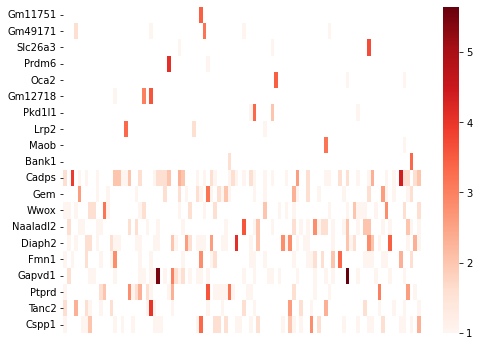

In [700]:
### Figure 1g

hm_df = np.array(np.log2(1+tds_mat.loc[list(sampled_prom_genes)+list(sampled_bursty_genes)][selection_of_cells]))
hm_df[hm_df==0]=np.nan
hm_df = pd.DataFrame(hm_df,index=list(sampled_prom_genes)+list(sampled_bursty_genes))

plt.figure(figsize=(8,6))
prom_hm = sb.heatmap(hm_df,cmap='Reds',xticklabels=False)
prom_hm.set_facecolor('white')

plt.savefig(fig_dir+'/Fig_1g.png')

##### Figure 1h

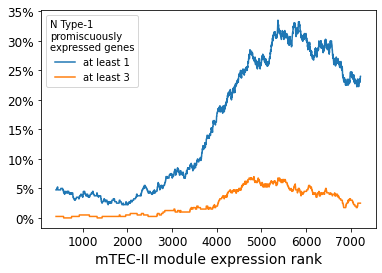

In [703]:
### Figure 1h

no_mtec4_wt_df = wt_cells_modules_score.loc[wt_cells_modules_score['mTEC-IV_mod']<module_thresh_values['mTEC-IV_mod']]
no_mtec4_wt_df=no_mtec4_wt_df.sort_values('mTEC-II_mod')
w_s = 400 # window size

### promiscuous expression as a function of mTEC-II
for t in [0,2]:
    curr_df = no_mtec4_wt_df.join(true_promiscuity_idx_wt.to_frame('exp'))
    curr_df['cell_idx'] = [i for i in range(len(curr_df))]
    
    sb.lineplot(x=curr_df['cell_idx'].to_numpy(),y=(curr_df['exp']>t).rolling(w_s,axis=0).mean())
    
    tick_labs = plt.gca().get_yticks()
    plt.xticks(size=12)
    plt.gca().set_yticklabels(labels=['%i%%' % (i*100) for i in tick_labs],size=12)
    plt.ylabel(None); plt.xlabel('mTEC-II module expression rank',size=14)
plt.legend(['at least 1','at least 3'],title='N Type-1a\npromiscuously\nexpressed genes')

plt.savefig(fig_dir+'/Fig_1h.png')

In [2051]:
sb.reset_orig()

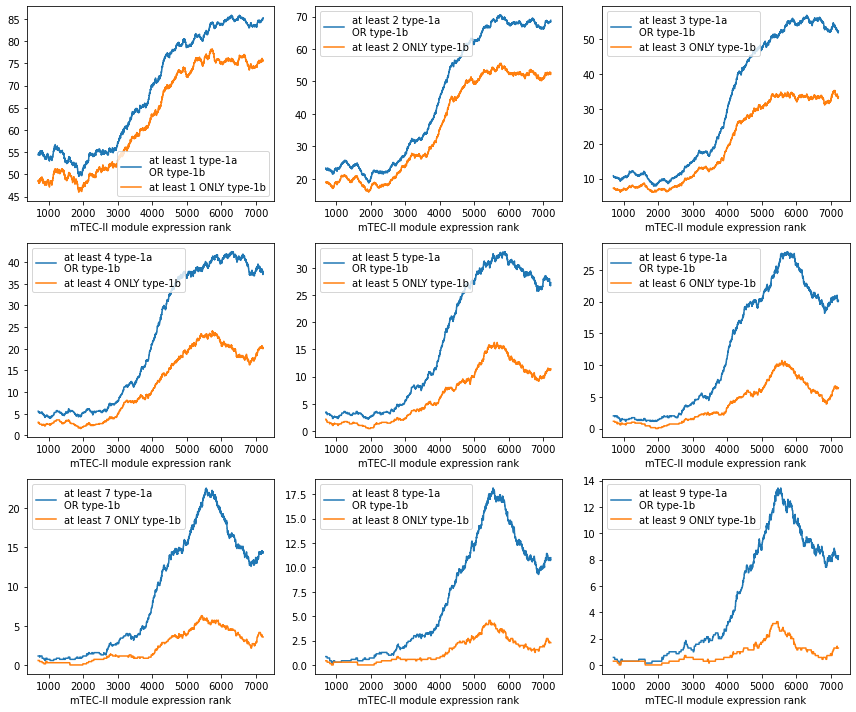

In [754]:
### bursty expression as a function of mTEC-II - comparison of different thresholds
### ==========================================

## blue line - % cells with at least 1 bursty OR promiscuous expression
## oreange line - % cells with at least 1 bursty expression
curr_df = no_mtec4_wt_df.join(pd.DataFrame({'any_prom_idx':prom_exp_df.loc[filtered_data_wt.obs_names].sum(axis=1),
                                 'type_1b_prom_idx':basal_promiscuity_idx_wt}))

w_s = 700 # window size

fig = plt.figure(figsize=(12,10))

thresholds = [i for i in range(9)]

curr_df['cell_idx'] = [i for i in range(len(curr_df))]

for thr in thresholds:
    ax_ = fig.add_subplot(3,3,thr+1)
    
    for t in ['any_prom_idx','type_1b_prom_idx']:\
        sb.lineplot(x=curr_df['cell_idx'].to_numpy(),y=(curr_df[t]>thr).rolling(w_s,axis=0).mean()*100,ax=ax_)

    plt.ylabel(None); plt.xlabel('mTEC-II module expression rank')
    
    plt.legend([f'at least {thr+1} type-1a\nOR type-1b',f'at least {thr+1} ONLY type-1b'])

plt.tight_layout()
fig.show()

##### Figure 1i

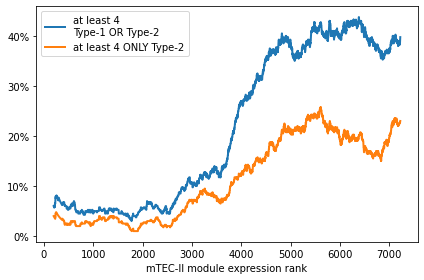

In [722]:
### Figure 1i

### bursty expression as a function of mTEC-II
### ===========================================

## blue line - % cells with at least 1 bursty OR promiscuous expression
## oreange line - % cells with at least 1 bursty expression
curr_df = no_mtec4_wt_df.join(pd.DataFrame({'any_prom_idx':prom_exp_df.loc[filtered_data_wt.obs_names].sum(axis=1),
                                 'type_1b_prom_idx':basal_promiscuity_idx_wt}))

# making sure cells are sorted by mTEC-II gene signature
curr_df = curr_df.sort_values('mTEC-II_mod')
w_s = 400 # window size

fig = plt.figure(figsize=(12,10))

curr_df['cell_idx'] = [i for i in range(len(curr_df))]

thr = 3
for t in ['any_prom_idx','type_1b_prom_idx']:
    if t=='any_prom_idx':
        sb.lineplot(x=curr_df['cell_idx'].to_numpy(),y=((curr_df[t])>thr).rolling(w_s,axis=0,min_periods=w_s//2).mean(),linewidth=2)
    else:
        sb.lineplot(x=curr_df['cell_idx'].to_numpy(),y=(curr_df[t]>thr).rolling(w_s,axis=0,min_periods=w_s//2).mean(),linewidth=2)

    tick_labs = plt.gca().get_yticks()
    plt.ylabel(None); plt.xlabel('mTEC-II module expression rank')
    plt.gca().set_yticklabels(labels=['%i%%' % (i*100) for i in tick_labs])
plt.legend([f'at least {thr+1}\nType-1a OR Type-1b',f'at least {thr+1} ONLY Type-1b'])

plt.tight_layout()
plt.savefig(fig_dir+'/Fig_1i.png')

In [65]:
### since we are aware to the existence of minor Thymocytes contamination in the data,
### we filter it out based on the gene module signature

no_t = prom_exp_df.loc[filtered_data_wt.obs_names].loc[~(score_log.loc[filtered_data_wt.obs_names,'Thymocytes_mod']>=module_thresh_values['Thymocytes_mod'])]
with_t = prom_exp_df.loc[filtered_data_wt.obs_names]

# no_t.index[(with_t) & (~no_t)][no_t.index[(with_t) & (~no_t)].isin(gene_modules.gene[gene_modules.module=='Thymocytes_mod'])]

# print(no_t)
# print(with_t)

#### gene gene correlation of type-1a promiuscously expressed genes

for simplicity reasons, in the following section:<br>
`type_1` = type-1a promiscuously expressed genes <br>
`type_2` = type-1b promiscuously expressed genes

In [895]:
type_1_pge_prom_df = no_t.loc[:,genes_basal_exp<0.05].loc[:,no_t.loc[:,genes_basal_exp<0.05].sum()>0]*1
type_2_pge_prom_df = no_t.loc[:,genes_basal_exp>0.2].loc[:,no_t.loc[:,genes_basal_exp>0.2].sum()>0]*1

In [66]:
type_1_pge_exp_df = ds_mat.loc[:,genes_basal_exp<0.05].loc[no_t.index,no_t.loc[:,genes_basal_exp<0.05].sum()>0]
type_2_pge_exp_df = ds_mat.loc[:,genes_basal_exp>0.2].loc[no_t.index,no_t.loc[:,genes_basal_exp>0.2].sum()>0]

In [67]:
type_1_genes = type_1_pge_exp_df.columns
type_2_genes = type_2_pge_exp_df.columns

In [76]:
### saving promiscuously expressed genes
pd.Series(list(type_1_genes)).to_csv(output_dir+'/type_1a_genes.csv')
pd.Series(list(type_2_genes)).to_csv(output_dir+'type_1b_genes.csv')

In [910]:
print(f"Total cells measured (excluding T cells): {no_t.shape[0]}")
print(f"Detected a total of {no_t.values.sum()} promiscuous expression events in {sum(no_t.sum(axis=1)>0)} cells")
print(f"Detected {no_t[type_1_genes].values.sum()} type-1a events from {len(type_1_genes)} genes")
print(f"Detected {no_t[type_2_genes].values.sum()} type-1b events from {len(type_2_genes)} genes")

Total cells measured (excluding T cells): 8611
Detected a total of 18144 promiscuous expression events in 5787 cells
Detected 1917 type-1a events from 843 genes
Detected 11767 type-1b events from 1597 genes


In [1792]:
### computing correlation

### based on promiscuous expression index
type_1_pge_cor = type_1_pge_prom_df.corr()
type_2_pge_cor = type_2_pge_prom_df.corr()

### based on downsampled UMI expression values
type1_pge_cor_exp = type_1_pge_exp_df.corr()
type2_pge_cor_exp = type_2_pge_exp_df.corr()

In [1804]:
np.fill_diagonal(type_1_pge_cor.values,0)
np.fill_diagonal(type_2_pge_cor.values,0)
np.fill_diagonal(type1_pge_cor_exp.values,0)
np.fill_diagonal(type2_pge_cor_exp.values,0)

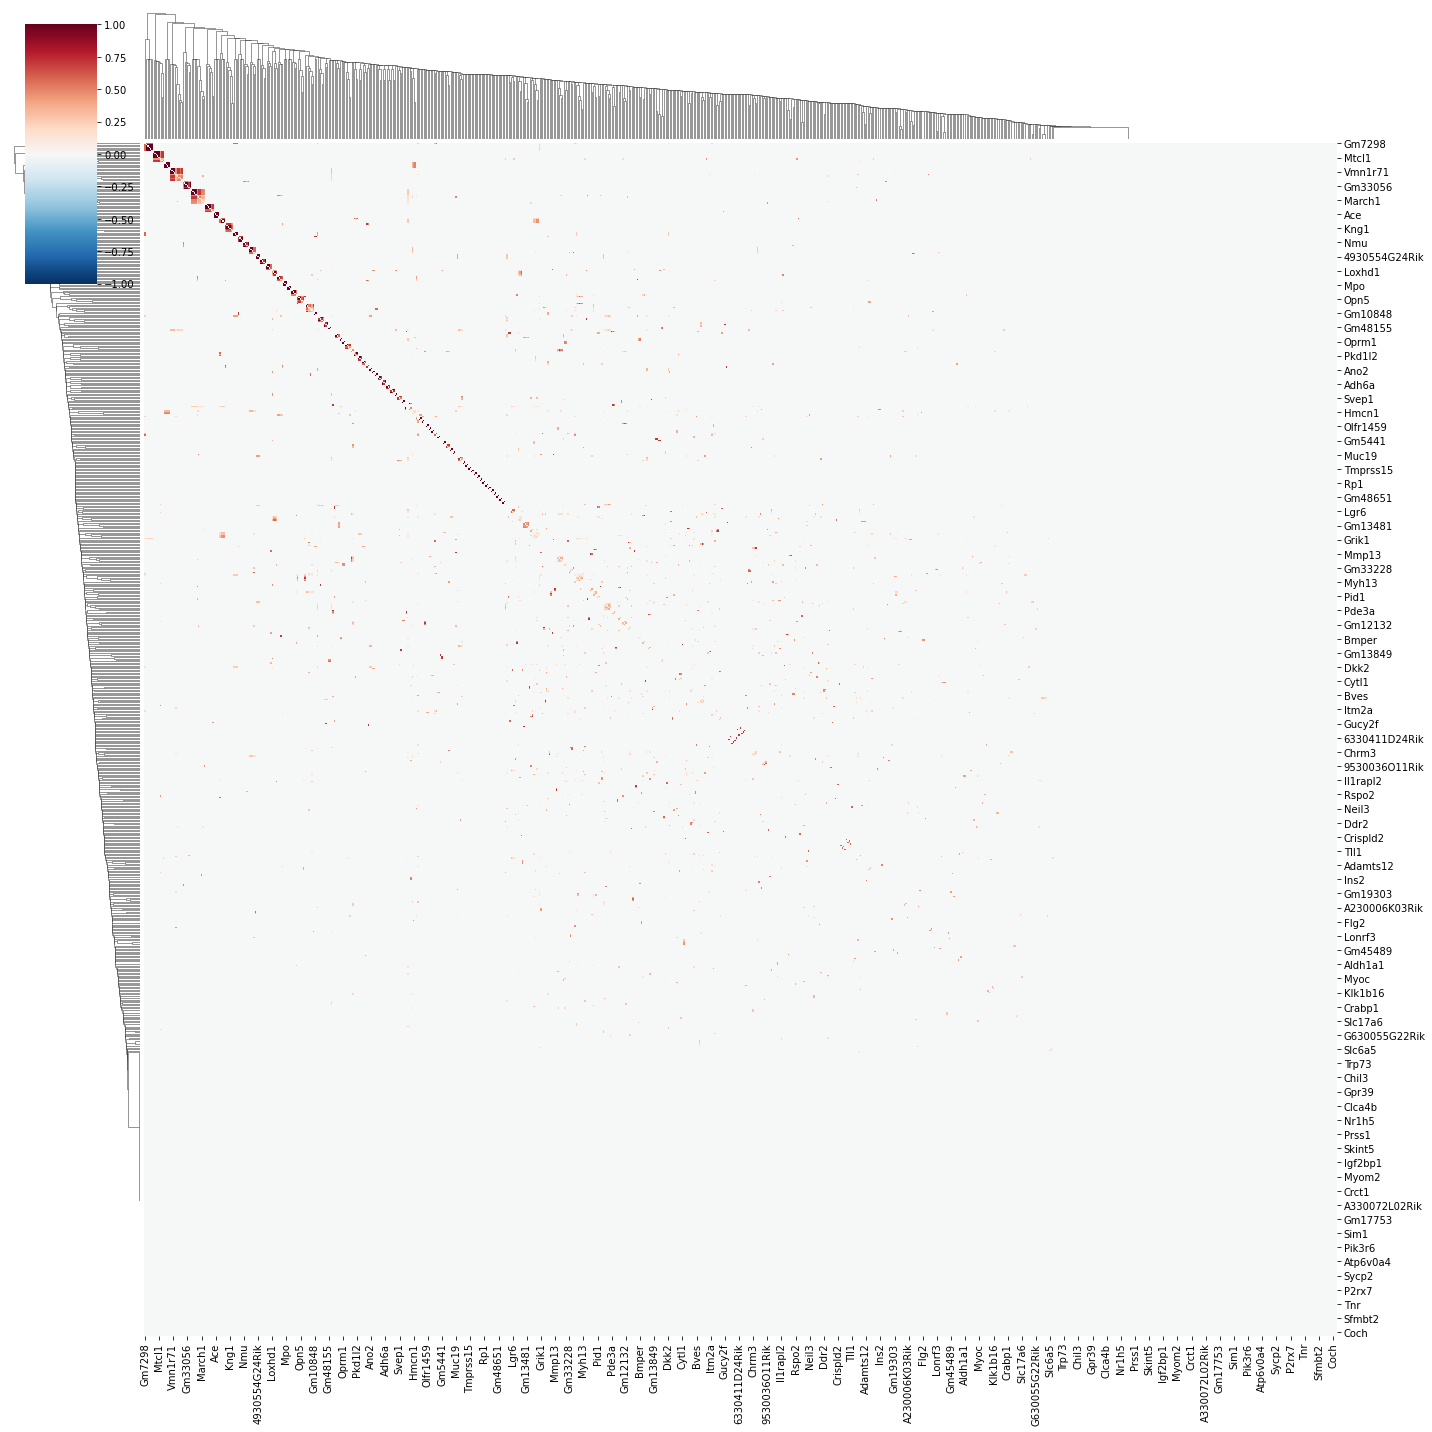

In [1935]:
sb.clustermap(type_1_pge_cor,cmap='RdBu_r',vmin=-1,dendrogram_ratio=0.1,figsize=[20,20])
# plt.savefig(fig_dir_png+'Fig 1/pge_correlations/type1_pge_cor.png')
# plt.savefig(fig_dir_pdf+'Fig 1/pge_correlations/type1_pge_cor.pdf')

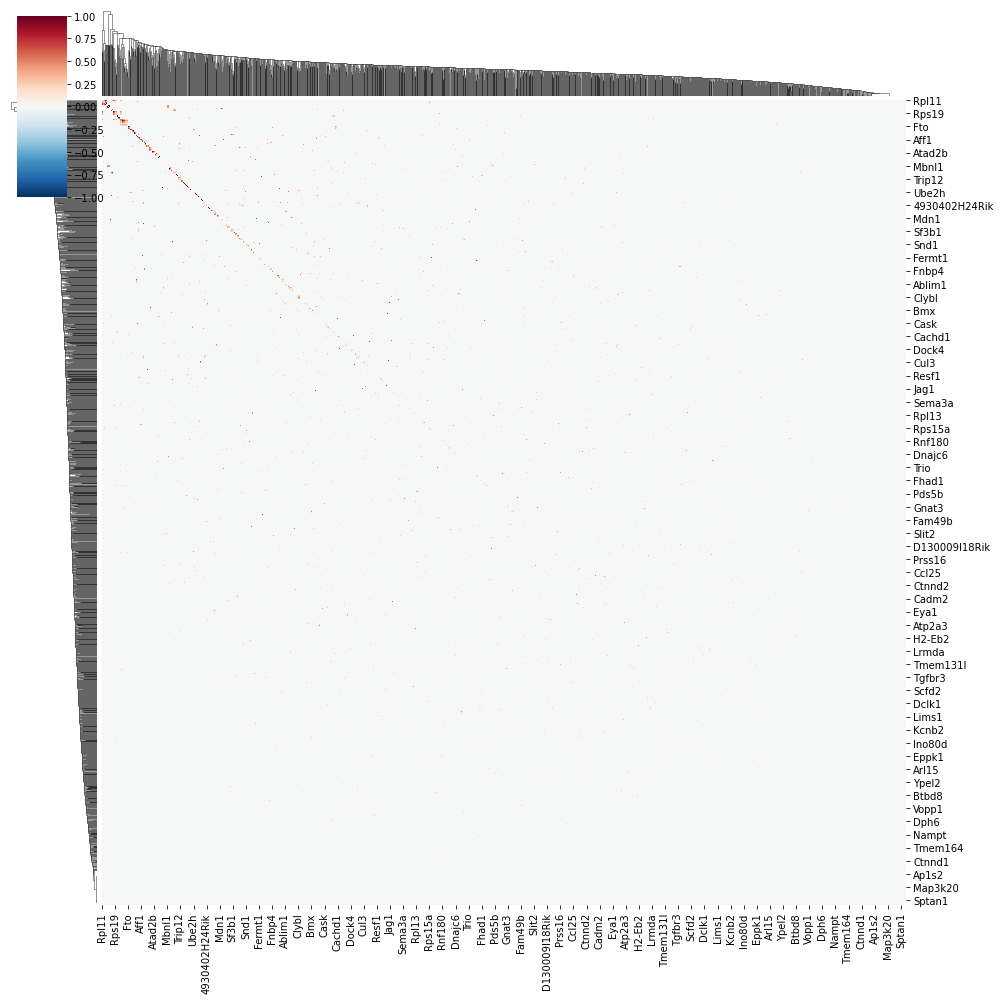

In [1817]:
sb.clustermap(type_2_pge_cor,cmap='RdBu_r',vmin=-1,dendrogram_ratio=0.1,figsize=[14,14])
# plt.savefig(fig_dir_png+'Fig 1/pge_correlations/type2_pge_cor.png')
# plt.savefig(fig_dir_pdf+'Fig 1/pge_correlations/type2_pge_cor.pdf')

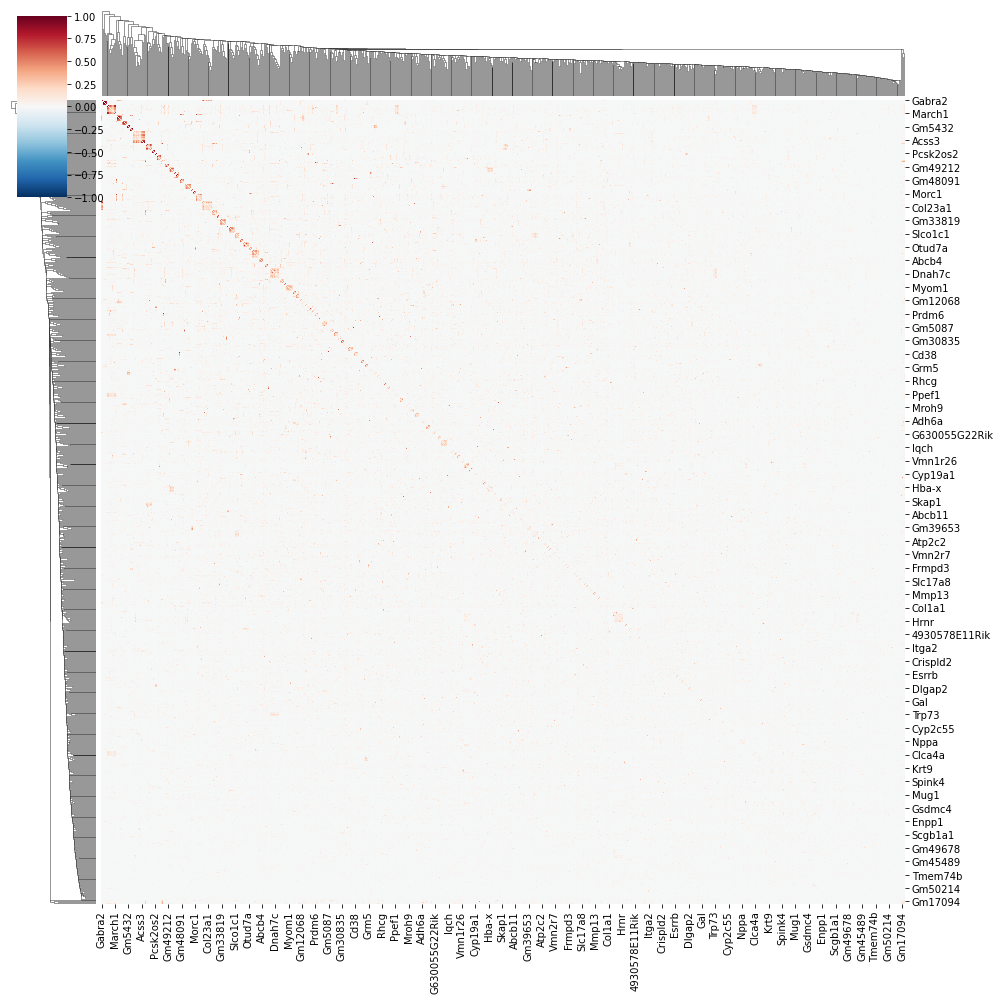

In [1818]:
sb.clustermap(type1_pge_cor_exp,cmap='RdBu_r',vmin=-1,vmax=1,dendrogram_ratio=0.1,figsize=[14,14])
# plt.savefig(fig_dir_png+'Fig 1/pge_correlations/type1_exp_cor.png')
# plt.savefig(fig_dir_pdf+'Fig 1/pge_correlations/type1_exp_cor.pdf')

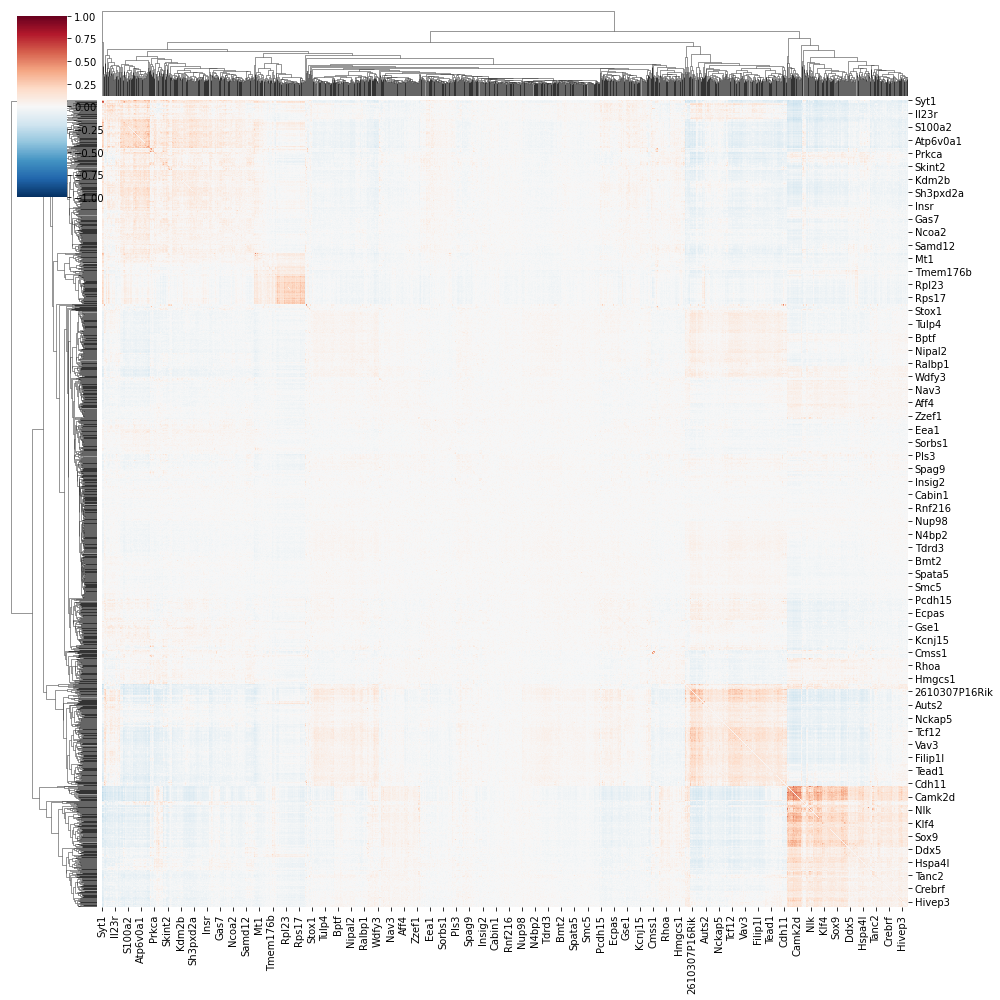

In [1819]:
sb.clustermap(type2_pge_cor_exp,cmap='RdBu_r',vmin=-1,vmax=1,dendrogram_ratio=0.1,figsize=[14,14])
# plt.savefig(fig_dir_png+'Fig 1/pge_correlations/type2_exp_cor.png')
# plt.savefig(fig_dir_pdf+'Fig 1/pge_correlations/type2_exp_cor.pdf')

#### Supp Fig 1f

for each signature, the number of Ia and Ib events relative to the global mean are computed. presented as a bargraph.

In [912]:
type1_glob_mean = no_t[type_1_genes].sum(axis=1).mean()
type2_glob_mean = no_t[type_2_genes].sum(axis=1).mean()

In [911]:
fig_a_df = pd.DataFrame(index=gene_modules.module.unique(),columns=['type1','type2'])

for mod in fig_a_df.index:
#     col=mod.replace("_mod","")
    copy_df = wt_cells_modules_score.loc[no_t.index].copy()
    
    cells_exp_mod = copy_df.index[copy_df[mod]>=module_thresh_values[mod]]
    n_type1_events_per_signature = np.mean(no_t.loc[cells_exp_mod,type_1_genes].sum(axis=1))
    n_type2_events_per_signature = np.mean(no_t.loc[cells_exp_mod,type_2_genes].sum(axis=1))
    
    fig_a_df.loc[mod,'type1'] = n_type1_events_per_signature
    fig_a_df.loc[mod,'type2'] = n_type2_events_per_signature

    # fig_a_df=fig_a_df.dropna()

In [913]:
fig_a_df['type-1a'] = fig_a_df['type1']/type1_glob_mean
fig_a_df['type-1b'] = fig_a_df['type2']/type2_glob_mean

In [935]:
fig_a_dfm = fig_a_df.reset_index().iloc[:,[0,-2,-1]].sort_values('type-1a').melt(id_vars='index')

## removing missing values
fig_a_dfm = fig_a_dfm.dropna()

In [940]:
fig_a_dfm['index']=fig_a_dfm['index'].astype('str')

In [941]:
fig_a_dfm['value_log']=np.log2(fig_a_dfm.dropna()['value'].astype('float'))

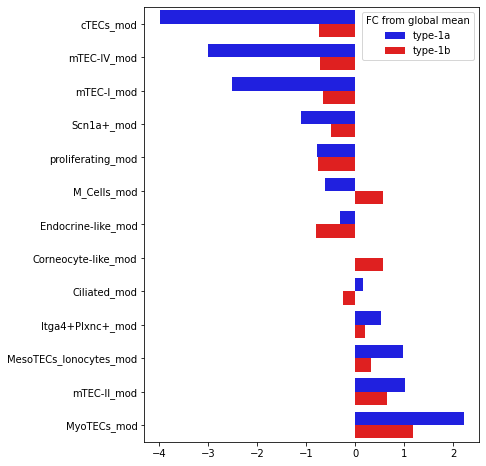

In [943]:
plt.figure(figsize=(6,8))
sb.barplot(fig_a_dfm[~fig_a_dfm['index'].isin(ignore_modules)],hue='variable',x='value_log',y='index',palette=['blue','red'])
plt.legend(title="FC from global mean")
plt.xlabel(None);plt.ylabel(None);

plt.savefig(fig_dir+'/Supp_fig_1f.png')

#### Supp fig 2b

after defining for each cell the number of typeI events, the correlation between this number and the expression of all genes (in a downsampled data) is computed. we report on the number of significant correlation, and show the top 20 significant genes (if we have such genes - expecting Aire to be there). 

In [1978]:
type1_pge_events_in_cells=no_t[type_1_genes].sum(axis=1)

genes_exp_corr_to_type1_pge_events = ds_mat.loc[no_t.index].apply(lambda x: stats.spearmanr(x,type1_pge_events_in_cells)).T
genes_exp_corr_to_type1_pge_events = genes_exp_corr_to_type1_pge_events.rename(columns={0:"cor",1:'p.val'})

### multiple comparisons correction using FDR (Benjamini-Yekutieli)
genes_exp_corr_to_type1_pge_events['p.val_adj']= mt.multipletests(genes_exp_corr_to_type1_pge_events['p.val'].fillna(0),method='fdr_by')[1]

### re-ordering the genes based on correlation coefficient
genes_exp_corr_to_type1_pge_events = genes_exp_corr_to_type1_pge_events.sort_values(['cor','p.val_adj'],ascending=[False,True])

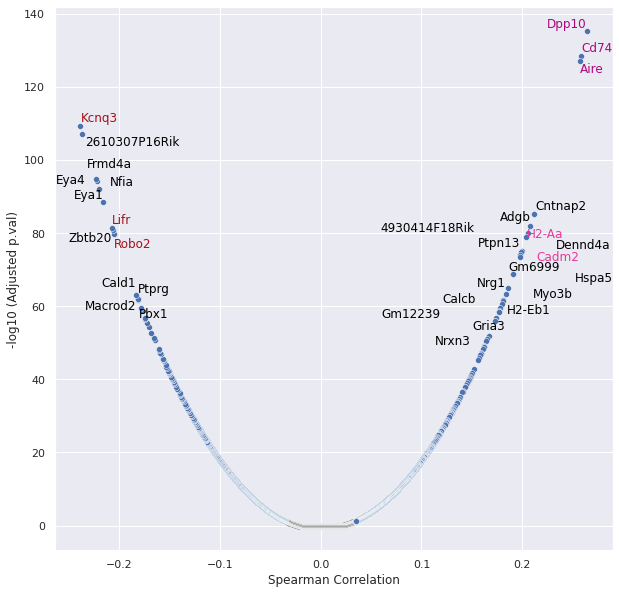

In [2061]:
sb.set(rc={'figure.figsize':(10,10)})
sb.scatterplot(x=genes_exp_corr_to_type1_pge_events.loc[genes_exp_corr_to_type1_pge_events['p.val_adj']>=0.05,'cor'],
               y=-np.log10(genes_exp_corr_to_type1_pge_events.loc[genes_exp_corr_to_type1_pge_events['p.val_adj']>=0.05,'p.val_adj']),
               color='black')

sb.scatterplot(x=genes_exp_corr_to_type1_pge_events.loc[genes_exp_corr_to_type1_pge_events['p.val_adj']<0.05,'cor'],
               y=-np.log10(genes_exp_corr_to_type1_pge_events.loc[genes_exp_corr_to_type1_pge_events['p.val_adj']<0.05,'p.val_adj']),
               )
texts=[]
for i in range(len(genes_exp_corr_to_type1_pge_events)):
    x=genes_exp_corr_to_type1_pge_events.iloc[i,:]['cor']
    y=(-np.log10(genes_exp_corr_to_type1_pge_events.iloc[i,:]['p.val_adj']))
    name = genes_exp_corr_to_type1_pge_events.index[i]
    color_nm='black'
    
    if name in list(gene_modules.gene):
        color_nm=modules_color_dict[genes_to_module_dict[name]]
        
    if genes_exp_corr_to_type1_pge_events.iloc[i,:]['p.val_adj']>=0.05:
        pass
    else:
        if (x>0.15) & (y>60):
            texts.append(plt.text(x=x,
                     y=y,
                     s=name,c=color_nm))
        elif (x<-0.15) & (y>60):
            texts.append(plt.text(x=x,
                     y=y,
                     s=name,c=color_nm))
adjustText.adjust_text(texts)

plt.ylabel('-log10 (Adjusted p.val)'); plt.xlabel("Spearman Correlation")

plt.savefig(fig_dir+'/Supp_fig_2b.png')

### KO - Figure 2

In [789]:
ko_cells_modules_score = score_log.loc[filtered_data_ko.obs_names]

#### Fig 2a - gene-gene corellation across cells

In [756]:
ds_mat_ko = ds_mat.loc[filtered_data_ko.obs_names]
ds_mat_ko_modules_genes = ds_mat_ko[gene_modules.gene[gene_modules.module!='mTEC-II_KO_mod']]

In [757]:
modules_gene_gene_cor_ko = ds_mat_ko_modules_genes.corr()
modules_gene_gene_cor_ko = pd.DataFrame(modules_gene_gene_cor_ko,index=ds_mat_ko_modules_genes.columns,columns=ds_mat_ko_modules_genes.columns)

In [758]:
row_cols = list(gene_modules.module[gene_modules.module!='mTEC-II_KO_mod'].map(modules_color_dict))

In [759]:
#### manually creating WT vs. KO correlation Matrix

joint_mat = np.zeros(modules_gene_gene_cor.shape)

for i in range(joint_mat.shape[0]):
    for j in range(joint_mat.shape[1]):
        if i>j:
            joint_mat[i,j]=modules_gene_gene_cor.values[i,j]
        else:
            joint_mat[i,j]=modules_gene_gene_cor_ko.values[i,j]
np.fill_diagonal(joint_mat,np.nan)            
joint_mat = pd.DataFrame(joint_mat,index=modules_gene_gene_cor.index,columns=modules_gene_gene_cor.index)

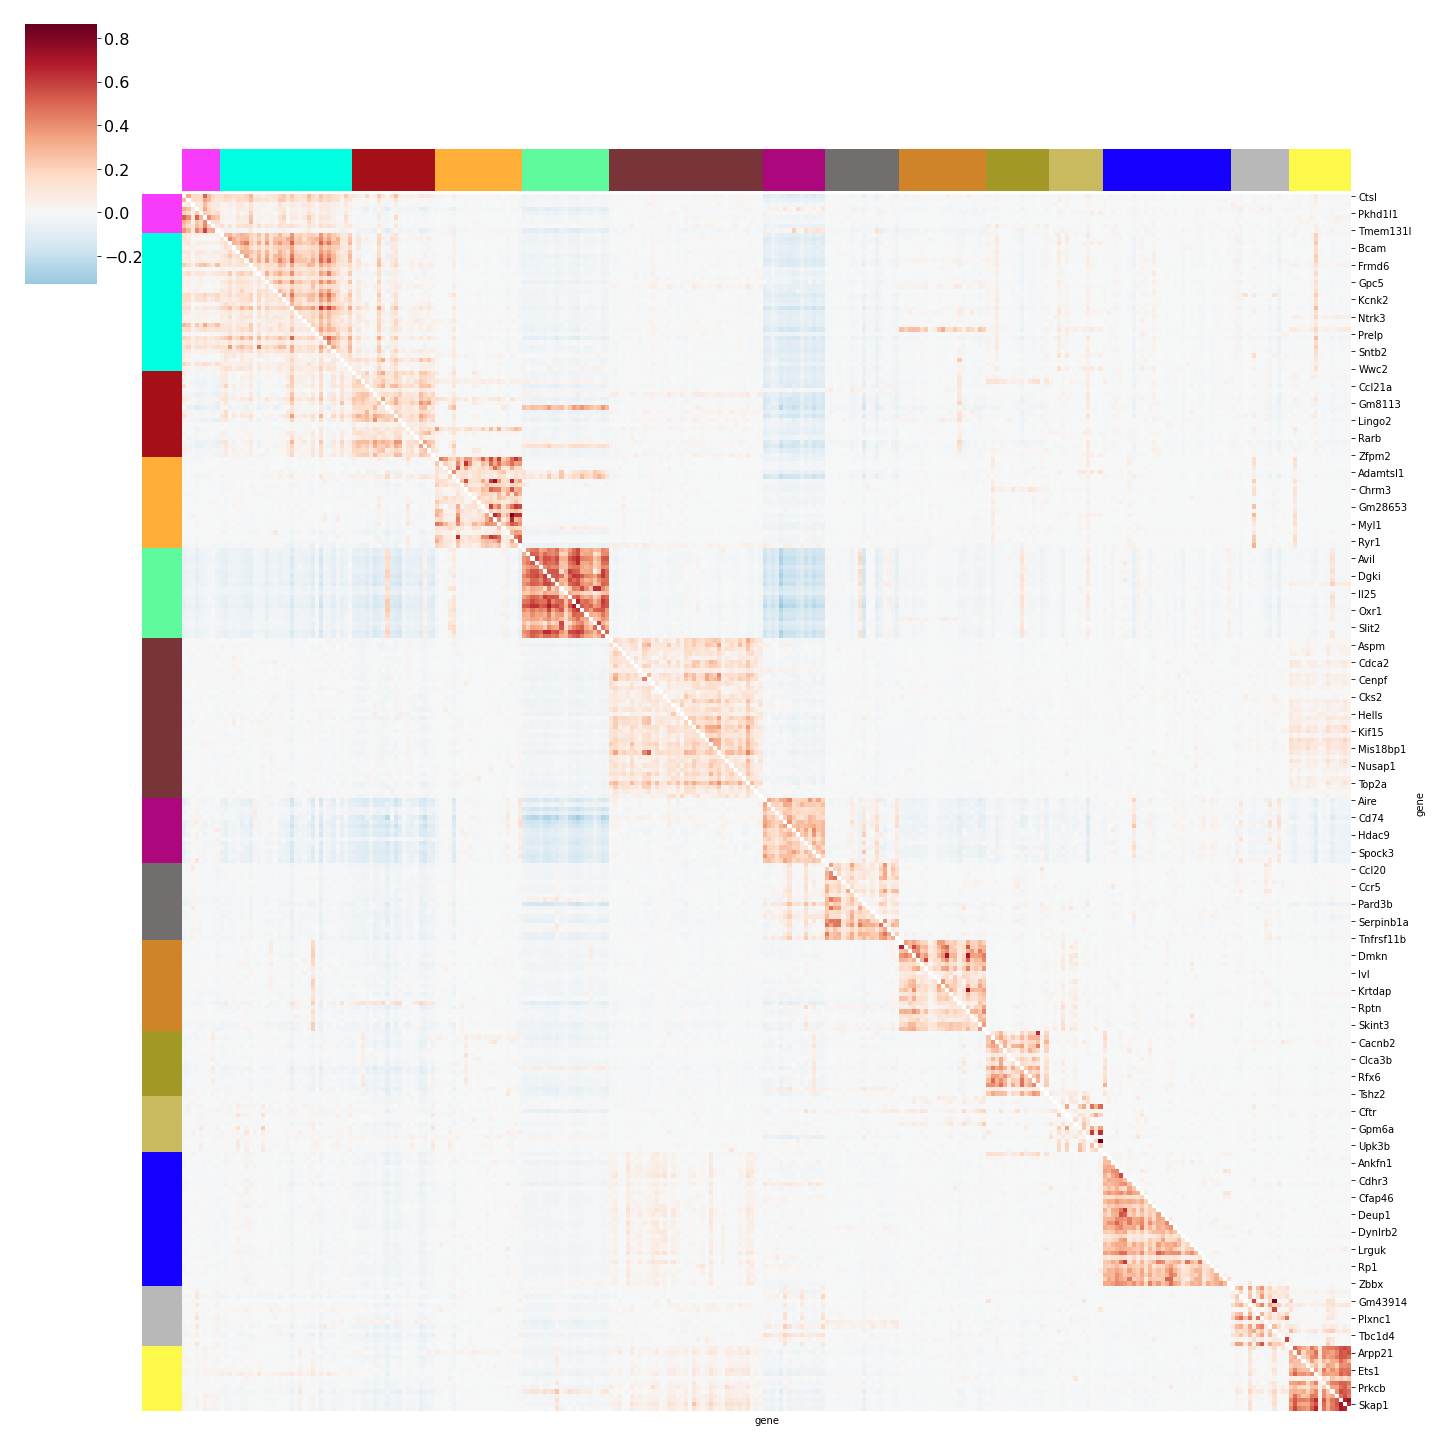

In [761]:
### Figure 2a

cm = sb.clustermap(joint_mat,cmap='RdBu_r',row_cluster=False,col_cluster=False,
              row_colors=row_cols,col_colors=row_cols,figsize=[20,20],center=0,dendrogram_ratio=0.1,
              xticklabels = False,
                   #yticklabels=[x if x in selected_genes_to_show else None for x in modules_gene_gene_cor.index],
              )
cm.ax_cbar.tick_params(labelsize=16)

plt.savefig(fig_dir+'/Fig_2a.png')

#### Fig 2b - Scatter of genes WT vs. KO on mTEC-IV, mTEC-I & mTEC-II modules-active single cells

for the purpose of generating this particular figure we use an in-house script and generate a proper dataset

In [2080]:
mods = ['mTEC-I_mod','mTEC-II_mod','mTEC-IV_mod']

In [2086]:
### Figure 2b
wd = fig_dir+'/2/'
os.chdir(wd)
    
# print("curr wd:"+os.getcwd())
for mod in mods:
    fn = f"{mod.replace(' ','_')}_mean_exp.csv"
    col = modules_color_dict[mod]
    
    ## subsetting for cells passing module activity threshold
    exp_cells = score_log[score_log[mod]>=module_thresh_values[mod]].index
    eps = (filtered_data.obs.loc[exp_cells,'total_umis'].median())**-1
    egc_genes_mean_exp_in_cells = np.log2(eps+sc_umis_fracs.loc[exp_cells]).join(filtered_data.obs.Sample).groupby('Sample').mean()
    
    ## exporting expression csv file
    egc_genes_mean_exp_in_cells.T.to_csv(wd+fn)
    
    cmnd = f"Rscript {fig_dir}/../create_wt_vs_ko_mean_expression_figs.R {fn},{col}"
    os.system(cmnd)
    
    print(mod,"DONE\n")

During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Received 1 Arguments:
file name: mTEC-I_mod_mean_exp_Feb23.csv
module_color: #A51018
file exists: TRUE
received file. module: mTEC-I_mod
Warning message:
ggrepel: 111 unlabeled data points (too many overlaps). Consider increasing max.overlaps 
saved figure


mTEC-I_mod DONE



During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Received 1 Arguments:
file name: mTEC-II_mod_mean_exp_Feb23.csv
module_color: #AD077E
file exists: TRUE
received file. module: mTEC-II_mod
Warning message:
ggrepel: 125 unlabeled data points (too many overlaps). Consider increasing max.overlaps 
saved figure


mTEC-II_mod DONE



During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Received 1 Arguments:
file name: mTEC-IV_mod_mean_exp_Feb23.csv
module_color: #5FFA9D
file exists: TRUE
received file. module: mTEC-IV_mod


mTEC-IV_mod DONE



Warning message:
ggrepel: 131 unlabeled data points (too many overlaps). Consider increasing max.overlaps 
saved figure


#### Fig 2c - mTEC-II gene signature distributions in Aire-WT vs. Aire-KO samples

In [2071]:
sb.reset_orig()

Text(0.5, 1.0, 'mTEC-II gene signature')

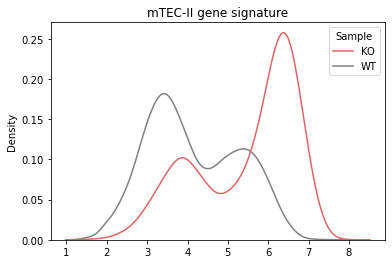

In [767]:
### Figure 2c
sb.kdeplot(data=score_log.join(filtered_data.obs['Sample']),x='mTEC-II_mod',hue='Sample',palette=['#df6464','gray'])
plt.xlabel(None); plt.title("mTEC-II gene signature")

plt.savefig(fig_dir+'/Fig_2c.png')

#### Fig 2d - SCATTER PLOT OF mTEC-I VS. mTEC-II SIGNATURES IN KO CELLS

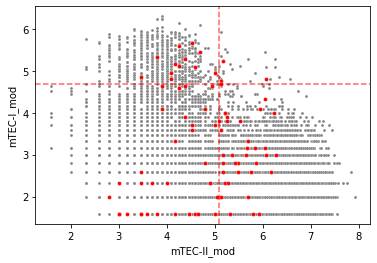

In [790]:
### Figure 2d
### SCATTER PLOT OF mTEC-I VS. mTEC-II SIGNATURES IN CELLS

# sb.displot(x=ko_cells_modules_score['mTEC-II_mod'],
#               y=ko_cells_modules_score['mTEC-I_mod'],kind='kde',color='black',alpha=0.3)

### first layer - cells that don't pass the proliferating threshold
prolif_active_cells = score_log.loc[filtered_data_ko.obs_names]['proliferating_mod']>=module_thresh_values['proliferating_mod']

sb.scatterplot(x=ko_cells_modules_score.loc[~prolif_active_cells,'mTEC-II_mod'],
              y=ko_cells_modules_score.loc[~prolif_active_cells,'mTEC-I_mod'],s=9,color='gray')

### second layer - cells that  pass the proliferating threshold
sb.scatterplot(x=ko_cells_modules_score.loc[prolif_active_cells,'mTEC-II_mod'],
              y=ko_cells_modules_score.loc[prolif_active_cells,'mTEC-I_mod'],s=16,color='red')

plt.axhline(y=module_thresh_values['mTEC-I_mod'],linestyle='--',color='red',alpha=0.6)
plt.axvline(x=module_thresh_values['mTEC-II_mod'],linestyle='--',color='red',alpha=0.6)

plt.savefig(fig_dir+'/Fig_2d')

#### Fig 2e - moving averages activation of gene modules as a function of mTEC-II score ranked

##### pre-processing

In [799]:
n_bins = 10

wt_bins_boundries = np.linspace(wt_cells_modules_score['mTEC-II_mod'].min(),wt_cells_modules_score['mTEC-II_mod'].max(),n_bins+1)

In [836]:
ko_cells_binned_on_mtec2_wt_scores = pd.cut(ko_cells_modules_score['mTEC-II_mod'],bins=wt_bins_boundries,labels=[i for i in range(1,n_bins+1)],include_lowest=True).rename('bin')
ko_cells_binned_on_mtec2_wt_scores[ko_cells_binned_on_mtec2_wt_scores.isna()]=ko_cells_binned_on_mtec2_wt_scores.max()

In [1653]:
plt.rcParams['figure.figsize']=[2.5,0.8]

##### plotting

In [184]:
### Figure 2e

if not os.path.exists(fig_dir+'Fig2_Moving_Averages'):
    os.mkdir(fig_dir+'Fig2_Moving_Averages')
    
### Note: we want to show the trendlines of the remaining gene modules as they appear in the WT bins.
## since the KO cells are highly enriched in the last bin (conditioned on WT boundries) - it is not informative enough to 
## order them according to mTEC-II module expression
## reminder: ~45-50% of all KO cells obtain higher mTEC-II module score than the WT top 10-th percentile.

mov_avg_df_ko = ko_cells_modules_score.join(ko_cells_binned_on_mtec2_wt_scores).sort_values('mTEC-II_mod')

## subset out mtec4 cells
mov_avg_df_ko = mov_avg_df_ko[mov_avg_df_ko['mTEC-IV_mod']<module_thresh_values['mTEC-IV_mod']]

mov_avg_df_ko['cell_idx'] = [i for i in range(len(mov_avg_df_ko))]

w_s = 400 # window size

### extracting where on the plot should we show the mean **WT-bin** enrichment result
locs=[]
for b in range(min(mov_avg_df_ko.bin.astype(int)),max(mov_avg_df_ko.bin.astype(int))+1):
    loc = min(np.where(mov_avg_df_ko.bin==b)[0])
    mid_loc = loc+(mov_avg_df_ko.value_counts('bin').sort_index()[b-1]//2) ## nudging to the middle
    locs.append(mid_loc)
    
mods=score_log.columns
# col=0
if 'bin' not in mov_avg_df.columns:
    mov_avg_df['bin'] = bin_data(mov_avg_df['mTEC-II_mod'])

for i in range(len(mods)):
    mod = mods[i]
    y_bg=mov_avg_df[mod].rolling(w_s,axis=0).apply(lambda x: sum(x>module_thresh_values[mod])/w_s)
    curr_df = mov_avg_df
    curr_df['mov_avg']=y_bg
    
    ## plotting the WT sample trendline as background
    plt.plot(locs,curr_df.groupby('bin')['mov_avg'].mean(),color='darkgray',linestyle='-',marker='o',alpha=0.5,linewidth=5,
            path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()])
    y=mov_avg_df_ko[mod].rolling(w_s,axis=0,center=True).apply(lambda x: sum(x>module_thresh_values[mod])/w_s)
    
    ## interpolating the sliding window edges(?)
    y_interpolated = y.interpolate(limit_direction='both')
    
    ## plotting the KO sample trendline as foreground
    s=sb.lineplot(x=mov_avg_df_ko.cell_idx,y=y_interpolated,color=modules_color_dict[mod],linewidth=5)
    s.set_yticklabels(['%.1f%%' % (i*100) for i in s.get_yticks()],size=14)
    plt.ylabel(None); plt.xlabel(None); plt.xticks([]);
    plt.text(0.02,1.05,s=mod.replace('.','-'),transform=s.transAxes,size=16)
    
    #saving figure
    plt.savefig(fig_dir+f'Fig2_Moving_Averages/{mod}_with_bg.png')
    
    plt.clf()
#     plt.show()

<Figure size 432x288 with 0 Axes>

#### Fig 2f-g promiscuous & burst expression as a function of mTEC-II score

The promiscuity index used thus far did not take into account the basal expression of the promiscuously expressed genes - so the index was composed of both "True" promiscuous abnormal expression and bursty ones

here we separate between the 2 categories

In [873]:
genes_basal_exp_ko = (sc_umis.loc[filtered_data_ko.obs_names]>0).sum()/filtered_data_ko.n_obs

In [874]:
true_promiscuity_idx_ko = prom_exp_df.loc[filtered_data_ko.obs_names,genes_basal_exp_ko<.05].sum(axis=1)
basal_promiscuity_idx_ko = prom_exp_df.loc[filtered_data_ko.obs_names,genes_basal_exp_ko>=.2].sum(axis=1)

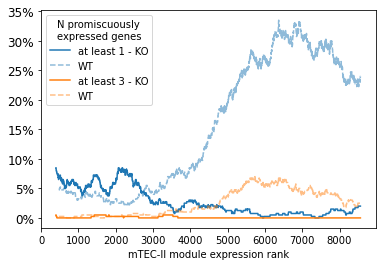

In [877]:
### Figure 2f

w_s = 400 # window size
    
### promiscuous expression as a function of mTEC-II signature
color_counter=0
plt.figure(figsize=(9,6))

for t in [0,2]:
    
    curr_df = mov_avg_df_ko.join(true_promiscuity_idx_ko.to_frame('exp')).sort_values('mTEC-II_mod')
    curr_df['cell_idx'] = [i for i in range(len(curr_df))]
    color=sb_colors[color_counter]
    
    sb.lineplot(x=curr_df['cell_idx'].to_numpy(),y=(curr_df['exp']>t).rolling(w_s,axis=0).mean())
    
    wt_df = no_mtec4_wt_df.join(true_promiscuity_idx_wt.to_frame('exp'))
    wt_df['cell_idx'] = [i for i in range(len(wt_df))]
    sb.lineplot(x=(wt_df['cell_idx'].to_numpy()/max(wt_df['cell_idx'])*max(curr_df['cell_idx'])),y=(wt_df['exp']>t).rolling(w_s,axis=0).mean(),c=color,linestyle=(0, (2, 3, 1, 3)),alpha=0.5)
    plt.ylabel(None);
    color_counter+=1
    
    plt.ylabel(None); plt.xlabel('mTEC-II module expression rank')

tick_labs = plt.gca().get_yticks()
plt.xticks(size=10);
plt.gca().set_yticklabels(labels=['%.0f%%' % (i*100) for i in tick_labs],size=16)
plt.legend(['at least 1 - KO','WT','at least 3 - KO','WT'],
           title='# promiscuously\nexpressed genes\n(type-1a)',prop={'size': 12},title_fontsize=14)
# plt.clf()

plt.savefig(fig_dir+'/Fig_2f.png')

In [747]:
plt.rcParams['figure.figsize']=[10,6]

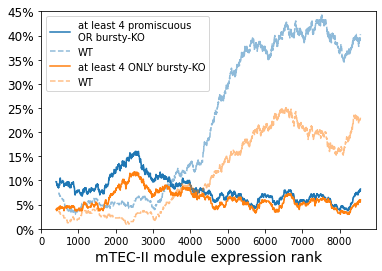

In [890]:
### Figure 2g

### bursty expression as a function opf mTEC-II
### ===========================================

## blue line - % cells with at least 1 bursty OR promiscuous expression
## oreange line - % cells with at least 1 bursty expression
curr_df = mov_avg_df_ko.sort_values('mTEC-II_mod').join(pd.DataFrame({'total_promiscuity_idx':prom_exp_df.loc[filtered_data_ko.obs_names].sum(axis=1),
                                                                      'basal_exp_idx':basal_promiscuity_idx_ko}))

w_s = 400 # window size

color_counter=0
plt.figure(figsize=(9,6))

for t in ['total_promiscuity_idx','basal_exp_idx']:
    
    curr_df['cell_idx'] = [i for i in range(len(curr_df))]

    color = sb_colors[color_counter]
    sb.lineplot(x=curr_df['cell_idx'].to_numpy(),y=(curr_df[t]>3).rolling(w_s,axis=0).mean())
    
    plt.ylim([0,0.45])
    plt.xlabel('mTEC-II module expression rank',size=14)
    
    wt_df = no_mtec4_wt_df.join(pd.DataFrame({'total_promiscuity_idx':prom_exp_df.loc[filtered_data_wt.obs_names].sum(axis=1),
                                                                      'basal_exp_idx':basal_promiscuity_idx_wt}))
    
    wt_df['cell_idx'] = [i for i in range(len(wt_df))]
    sb.lineplot(x=(wt_df['cell_idx'].to_numpy()/max(wt_df['cell_idx'])*max(curr_df['cell_idx'])),y=(wt_df[t]>3).rolling(w_s,axis=0).mean(),c=color,linestyle='--',alpha=0.5)
    plt.ylabel(None);
    color_counter+=1

tick_labs = plt.gca().get_yticks()
plt.xticks(size=10);
plt.gca().set_yticklabels(labels=['%.0f%%' % (i*100) for i in tick_labs],size=16)
plt.legend(['at least 4 type-1a\nOR type-1b - KO','WT','at least 4 ONLY type-1b - KO','WT'],loc='upper left',
          title_fontsize=14,prop={'size':12})

plt.savefig(fig_dir+'/Fig_2g.png')

## Saving Outputs

In [976]:
pd.Series(modules_color_dict).to_csv(output_dir+'/modules_color_dict.csv')
ds_mat.to_csv(output_dir+'/ds_mat.csv')
score_log.to_csv(output_dir+'/score_log.csv')
modules_activity[['Module','Sample']].to_csv(output_dir+'/modules_activity.csv')
pd.DataFrame(prom_exp_df,dtype='int64').to_csv(output_dir+'/prom_exp_df.csv')

### exporting colnames for explicitly setting column names when loading the tables in R

In [18]:
with open(output_dir+'/score_log_colnames.txt','w') as out_f:
    for colname in score_log.columns:
        out_f.write(colname+'\n')

should be set for `ds_mat` and `prom_exp_df`

In [21]:
# should be set for `ds_mat` and `prom_exp_df`
with open(output_dir+'/genes_colnames.txt','w') as out_f:
    for colname in ds_mat.columns:
        out_f.write(colname+'\n')

## Switching to R for ATAC analysis (i.e., mTECs chromatin accessibility)

Using the mcATAC package

the necessary dataframes accumulated thus far:
- `ds_mat` = single cells downsampled expression matrix
- `gene_modules` = a table of derived feature genes that characterize different subpopulations of thymic epithelial cells
- `score_log` = an expression matrix accumulating genes into distinct modules assigning a signature score per-cell
- `modules_activity` = a classification table of cells into cell-types, given a sufficient score of the appropriate gene signature. This allows us to identify cells that either exclusively express only one module, or may potentially express more than one program in parallel, so likely to result in greater number of cells. 
- `prom_exp_df` = a promiscuous expression table, marking events of promiscuous expression activity per-cell across all genes. using a threshold of 8-fold from expected expression profile for each cell specifically.